# AmeriaBank Clustering

Preparation

GPU runtime is neccessary to run the code below

In [ ]:
%%capture

from google.colab import drive
import sys
import os
import matplotlib.font_manager as fm

current_path = '/content/drive/MyDrive/ameriabank'

drive.mount('/content/drive')
sys.path.append(current_path)
os.chdir(current_path)

!pip install optuna kmodes catboost shap faiss-cpu
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

from utils import *
from utils_cpu import *

fm.fontManager.addfont('OpenSans[wdth,wght].ttf')
plt.rcParams['font.family'] = ['Open Sans']

In [ ]:
df_total = cudf.read_parquet('df_total.parquet')
df_total = df_total[df_total['Residence_AM'] == 1]

acra_new_g1 = cudf.read_parquet('acra_new_g1.parquet')
acra_new_g2 = cudf.read_parquet('acra_new_g1.parquet')
acra_new_g1.index = acra_new_g1.index.astype(str) + '_1'
acra_new_g2.index = acra_new_g2.index.astype(str) + '_2'

df_g1 = df_total[df_total.index.str.endswith('_1')]
df_g2 = df_total[df_total.index.str.endswith('_2')]

trans_g1 = cudf.read_parquet('tr_cnt_total_gr1.parquet').dropna()
trans_g1.index = trans_g1.index.astype(str) + '_1'

*The new ACRA data has some issues:*
- *The date is out of time comparing to the origin dataset;*
- *The last column 'Ever had loan in Ameriabank' contains strange values (not 0 or 1).*

*So I suggest not to use it together with origin data.*

In [ ]:
acra_new_g1.head()

,DateTime,SwitchisClassQuantity,TheWorstClassLoan,RequestQuantity30,RequestQuantity365,TheWorsClassGuarantee,RequestedBanksCount365,NewLoanRequestQuantity365,FICOScore,ActiveOtherLoansCount,...,MonthsUntilLastCreditCompletion,TotalActiveLoansBalance,MaxLoanBalance,ActiveLoanKindCount,DelayedPaymentsForActiveCredits,PaidGuaranteesCount,PaidGuaranteesBankCount,ActiveGuaranteesCount,ActiveGuaranteesBankCount,Ever had loan in Ameriabank
CODE,,,,,,,,,,,,,,,,,,,,,
5821_1,2024-07-13 15:55:09,1.0,0.0,3.0,18.0,<NA>,2.0,7.0,541.0,<NA>,...,205.0,21287100.0,17102659.0,1.0,No,1.0,1.0,<NA>,<NA>,1
59809_1,2024-08-21 02:05:30,2.0,0.0,0.0,14.0,<NA>,3.0,4.0,542.0,1.0,...,52.0,2163601.0,1300843.0,3.0,No,<NA>,<NA>,<NA>,<NA>,0
62029_1,2024-09-17 08:10:18,2.0,0.0,2.0,14.0,<NA>,<NA>,<NA>,619.0,1.0,...,12.0,145742.0,145742.0,1.0,No,1.0,1.0,<NA>,<NA>,1
36383_1,2024-07-17 01:34:12,0.0,<NA>,0.0,8.0,<NA>,<NA>,<NA>,744.0,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
67140_1,2024-08-30 03:45:39,66.0,4.0,1.0,19.0,<NA>,<NA>,<NA>,490.0,<NA>,...,26.0,1429415.0,552400.0,2.0,Yes,<NA>,<NA>,<NA>,<NA>,0


## Main Bank (group1) customers clustering

### Preprocess the group 1 data

#### Preprocess features


In [ ]:
data = df_g1.copy()
data = data[~data.index.duplicated(keep='first')]

# Rename some columns

data = data.rename(columns=col_rename_dict)

# One-hot encoding

data = cudf.get_dummies(
    data,
    columns=['MARITAL_STATUS'],
    prefix=['marital_status'],
    dtype=int
    )

# Generating new features

data['salary'] = cp.where(
    data['Average_Income'] > 0, data['Average_Income'],
    cp.where(data['Salary'] > 0, data['Salary'], 0)
    ).astype(int)

data['crd_car_loan_cnt'] = data['prCar Loans / Manual'] + data['prCar Loans / Scoring']
data['crd_unsecured_loan_cnt'] = data['prPersonal unsecured loans / Manual'] + data['prPersonal unsecured loans / Scoring']
data['crd_overdraft_loan_cnt'] = data['prPlastic Cards / Manual'] + data['prPlastic Cards / Scoring']

pr_cols = [col for col in data.columns if col.startswith('pr')]
data = data.drop(columns=pr_cols)

cnt_cols = [col for col in data.columns if col.endswith("_cnt")]
for col in cnt_cols:
    data[f'{col[:-3]}flag'] = (data[col]>0)*1

crd_flag_cols = [col for col in data.columns if col.startswith('crd_') and col.endswith('_flag')]
dbt_flag_cols = [col for col in data.columns if col.startswith('dbt_') and col.endswith('_flag')]
ch_flag_cols = [col for col in data.columns if col.startswith('ch_') and col.endswith('_flag')]

data['crd_types_cnt'] = data[crd_flag_cols].sum(axis=1).astype('int8')
data['dbt_types_cnt'] = data[dbt_flag_cols].sum(axis=1).astype('int8')
data['prd_types_cnt'] = data['crd_types_cnt'] + data['dbt_types_cnt']
data['ch_types_cnt'] = data[ch_flag_cols].sum(axis=1).astype('int8')

data['bank_income_comissions'] = data[
    ['Commission from transfers', 'Commissions from Cards', 'Other Commissions', 'Cash-non cash commission']
    ].sum(axis=1)


data['dbt_paycard_above2'] = (data['dbt_paycard_cnt']>2)*1
data['dbt_savings_above2'] = (data['dbt_savings_cnt']>2)*1

data['fico_nonzero'] = (data['FICOScore'] > 0)*1

# Dropping outliers
outlier_feats = ['salary', 'Balance_avg', 'avg_total_income']

no_outliers_data = drop_outliers(data, outlier_feats)
outliers_indices = data.index.difference(no_outliers_data.index)
outliers_data = data.loc[outliers_indices, :]

# Dropping sparse cols
data_clean, sc = drop_sparse_cols(no_outliers_data, .98)

In [ ]:
data_clean

,Average_Income,age,gender_type,life_time,SwitchisClassQuantity,TheWorstClassLoan,RequestQuantity30,RequestQuantity365,TheWorsClassGuarantee,RequestedBanksCount365,...,dbt_savings_flag,crd_unsecured_loan_flag,crd_overdraft_loan_flag,crd_types_cnt,dbt_types_cnt,prd_types_cnt,ch_types_cnt,bank_income_comissions,dbt_paycard_above2,fico_nonzero
CODE,,,,,,,,,,,,,,,,,,,,,
70845_1,1.702953e+06,34,1,24,0,0,0,0,0,0,...,0,0,0,0,1,1,1,3029.356000,1,0
84280_1,1.701900e+06,21,1,15,0,0,2,8,0,0,...,0,0,0,0,1,1,1,5191.376667,0,0
55128_1,1.701750e+06,64,0,38,0,0,0,0,0,0,...,0,0,0,0,1,1,1,787.490333,0,0
13643_1,1.701217e+06,32,1,96,0,6,0,6,0,1,...,0,0,0,0,1,1,2,5268.944333,1,0
50017_1,1.700030e+06,31,1,45,0,6,2,18,0,2,...,1,0,1,1,2,3,1,6043.075000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675_1,6.000000e+02,58,1,126,0,6,0,2,0,0,...,0,0,0,0,1,1,1,0.000000,0,1
56539_1,4.500000e+02,31,1,37,0,6,1,15,0,5,...,0,0,0,0,1,1,1,218.893333,0,1
95331_1,3.000000e+02,19,1,7,0,0,0,2,0,0,...,0,0,0,0,1,1,1,400.120000,0,0


#### Preprocess transactions

In [ ]:
trans = trans_g1.copy()

for k, v in mcc_groups.items():
    trans[k] = trans[v].sum(axis=1)

trans = trans[list(mcc_groups.keys())]

trans

,Супермаркеты,Рестораны,Одежда,Аптеки,Красота,Финансы,Такси,Курьерская доставка,Топливо и авто,Розничные магазины,Коммунальные услуги,Азартные игры
CODE,,,,,,,,,,,,
0_1,1.0,1.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
1_1,16.0,11.0,0.0,1.0,1.0,55.0,19.0,0.0,0.0,9.0,8.0,0.0
2_1,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,1.0,1.0,0.0,104.0
3_1,43.0,21.0,2.0,2.0,0.0,32.0,11.0,0.0,0.0,1.0,0.0,0.0
4_1,85.0,35.0,2.0,2.0,0.0,42.0,19.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
98231_1,0.0,2.0,3.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0
98232_1,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
98233_1,14.0,12.0,10.0,0.0,0.0,12.0,0.0,0.0,0.0,2.0,0.0,0.0


#### Merge features and transactions data

In [ ]:
df = cudf.concat([data_clean, trans], axis=1, join='outer')
df

,Average_Income,age,gender_type,life_time,SwitchisClassQuantity,TheWorstClassLoan,RequestQuantity30,RequestQuantity365,TheWorsClassGuarantee,RequestedBanksCount365,...,Одежда,Аптеки,Красота,Финансы,Такси,Курьерская доставка,Топливо и авто,Розничные магазины,Коммунальные услуги,Азартные игры
CODE,,,,,,,,,,,,,,,,,,,,,
70845_1,1702952.8,34,1,24,0,0,0,0,0,0,...,0.0,6.0,3.0,15.0,77.0,3.0,0.0,27.0,0.0,0.0
84280_1,1701900.0,21,1,15,0,0,2,8,0,0,...,1.0,6.0,3.0,5.0,48.0,0.0,0.0,4.0,0.0,0.0
55128_1,1701750.0,64,0,38,0,0,0,0,0,0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,2.0,0.0,0.0
13643_1,1701216.667,32,1,96,0,6,0,6,0,1,...,5.0,28.0,0.0,53.0,72.0,0.0,4.0,7.0,0.0,0.0
50017_1,1700030.0,31,1,45,0,6,2,18,0,2,...,1.0,21.0,2.0,14.0,0.0,0.0,6.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98058_1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,4.0,1.0,12.0,17.0,0.0,1.0,0.0,9.0,4.0,0.0
98180_1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,2.0,0.0,46.0,0.0,0.0,2.0,2.0,0.0,0.0
98198_1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,1.0,4.0,0.0,77.0,0.0,3.0,12.0,12.0,0.0,0.0


### Clustering with Optuna sampling

#### Get clusters using sampler

In [ ]:
opt_params = {
    'sampler': TPESampler(),
    'metric': 'silhouette',
    'direction': 'maximize',
    'obj_func': objective,
    'major_label_share': .6,
    'minor_label_cnt': 100,
    'drop_hdbscan': False,
    'timeout': 400
}

trials_dict = {
    'behavioral': 100,
    'product': 100,
    'finance': 100,
    'personal': 100,
    'trans': 100
}

pca_dict = {
    'behavioral': False,
    'product': False,
    'finance': False,
    'personal': False,
    'trans': True
}

clusters_cnt_max_dict = {
    'behavioral': 11,
    'product': 12,
    'finance': 5,
    'personal': 9,
    'trans': 6
}

clusters_cnt_min_dict = {
    'behavioral': 11,
    'product': 12,
    'finance': 5,
    'personal': 9,
    'trans': 6
}


selected_feats = selected_domain_features.copy()

# trans_ix Index usage is optional (for equal results)

filename = 'domains'
results = train_and_save(
    filename=filename,
    selected_feats=selected_feats,
    trials_dict=trials_dict,
    pca_dict=pca_dict,
    clusters_cnt_max_dict=clusters_cnt_max_dict,
    clusters_cnt_min_dict=clusters_cnt_min_dict,
    data=df,
    trans_ix=trans_g1.index,
    **opt_params
    )



start  behavioral 

df shape:  (83338, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-20 05:17:38,587] Trial 0 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 10, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:17:38,779] Trial 1 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 5, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:17:40,042] Trial 2 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'HDBSCAN', 'min_cluster_size': 1100, 'min_samples': 100, 'cluster_selection_method': 'eom', 'cluster_selection_epsilon': 0.7000000000000001}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:17:43,012] Trial 3 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'HDBSCAN', 'min_cluster_size': 800, 'min_samples': 300, 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.0}. Best is trial 0 with value

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-20 05:19:02,685] Trial 0 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 11, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:19:07,288] Trial 1 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'HDBSCAN', 'min_cluster_size': 900, 'min_samples': 700, 'cluster_selection_method': 'eom', 'cluster_selection_epsilon': 0.4}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:19:07,517] Trial 2 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 10, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:19:07,724] Trial 3 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 6, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:19:12,362] Trial 4 finished with value: -0

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-20 05:21:30,338] Trial 0 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 5, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:21:33,787] Trial 1 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'HDBSCAN', 'min_cluster_size': 1500, 'min_samples': 1000, 'cluster_selection_method': 'eom', 'cluster_selection_epsilon': 0.1}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:21:36,820] Trial 2 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'HDBSCAN', 'min_cluster_size': 1500, 'min_samples': 400, 'cluster_selection_method': 'eom', 'cluster_selection_epsilon': 0.7000000000000001}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:21:37,024] Trial 3 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 8, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-20 05:25:34,411] Trial 0 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'DBSCAN', 'eps': 0.30000000000000004, 'min_samples': 800}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:25:34,604] Trial 1 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 6, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:25:34,803] Trial 2 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 7, 'init': 'k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:25:35,082] Trial 3 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'DBSCAN', 'eps': 0.30000000000000004, 'min_samples': 400}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:25:37,597] Trial 4 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'HDBSCAN', 'min_cluster_size': 600, 'min

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-20 05:26:51,670] Trial 0 finished with value: -0.5 and parameters: {'pca_threshold': 0.5, 'method': 'KMeans', 'n_clusters': 10, 'init': 'k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:26:51,892] Trial 1 finished with value: -0.5 and parameters: {'pca_threshold': 0.5, 'method': 'KMeans', 'n_clusters': 7, 'init': 'k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:26:52,101] Trial 2 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 9, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:26:52,323] Trial 3 finished with value: -0.5 and parameters: {'pca_threshold': False, 'method': 'KMeans', 'n_clusters': 12, 'init': 'scalable-k-means++', 'max_iter': 300}. Best is trial 0 with value: -0.5.
[I 2024-10-20 05:26:52,531] Trial 4 finished with value: -0.5 and parameters: {'pca_threshold': 0.3, 'method': 'KMeans', 'n_clusters

#### Visualize clusters

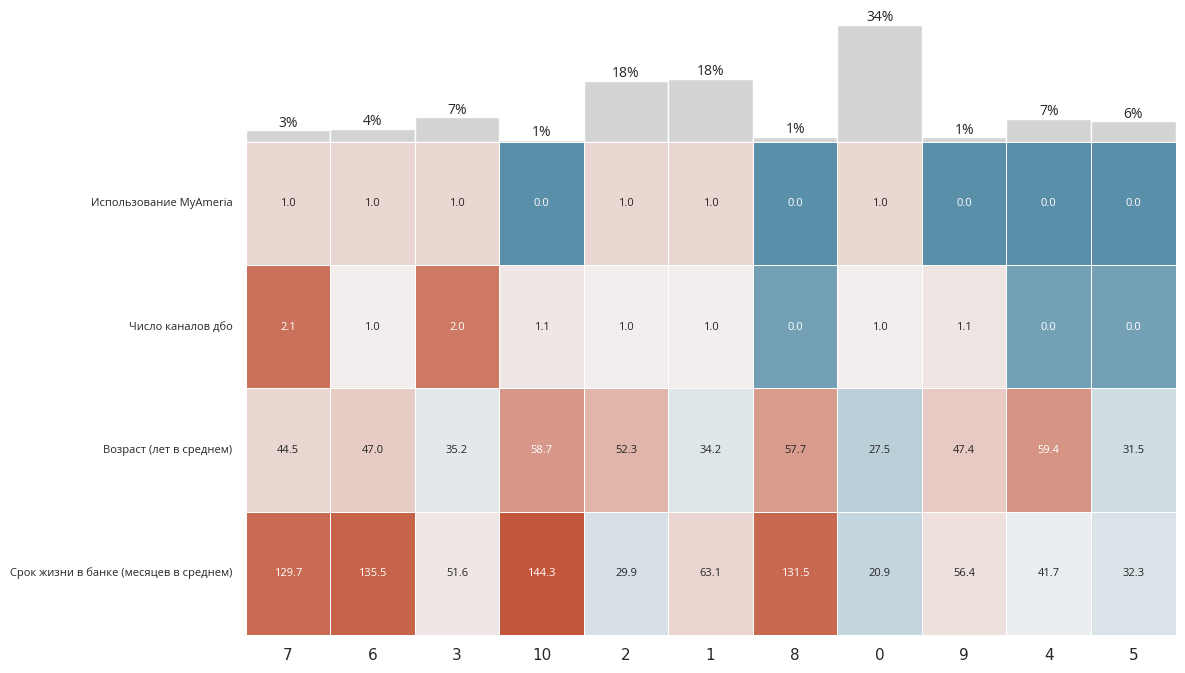

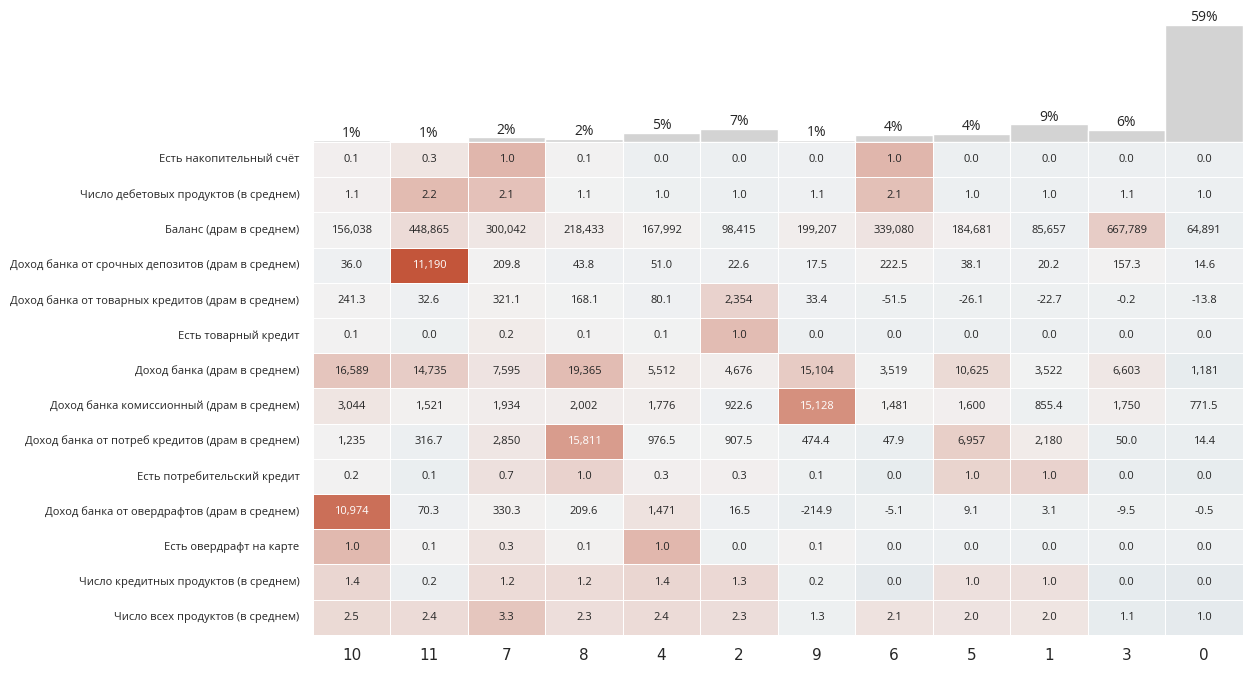

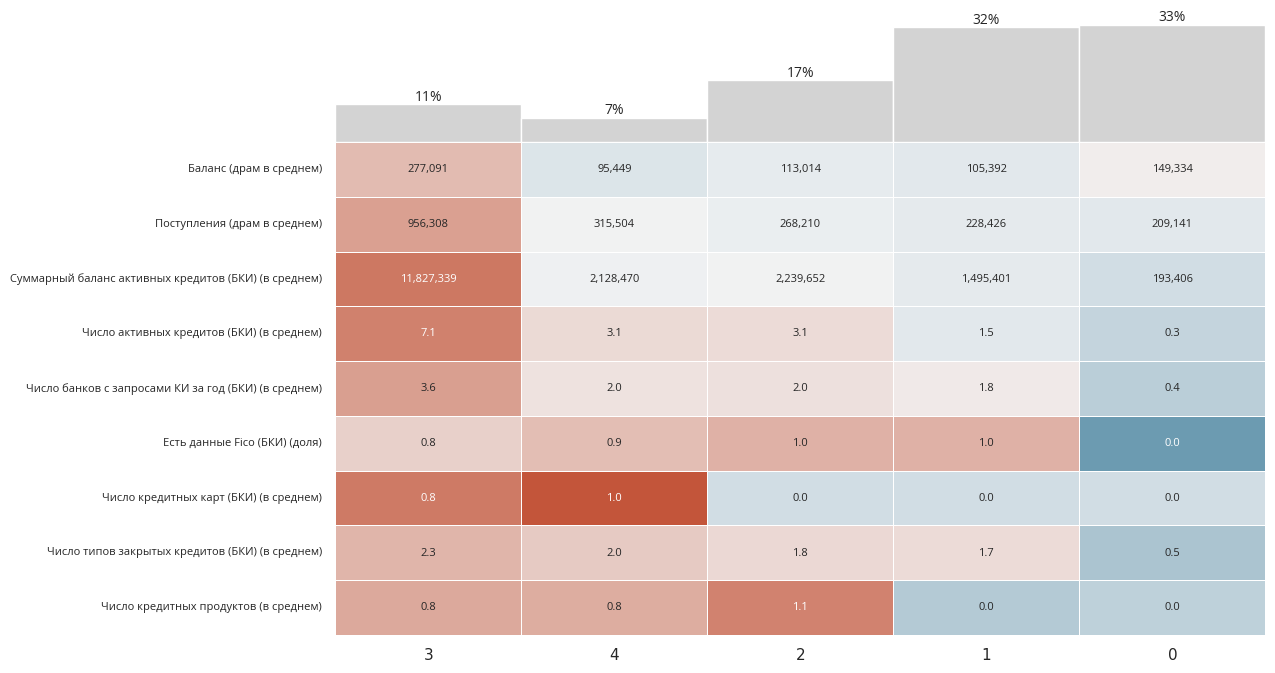

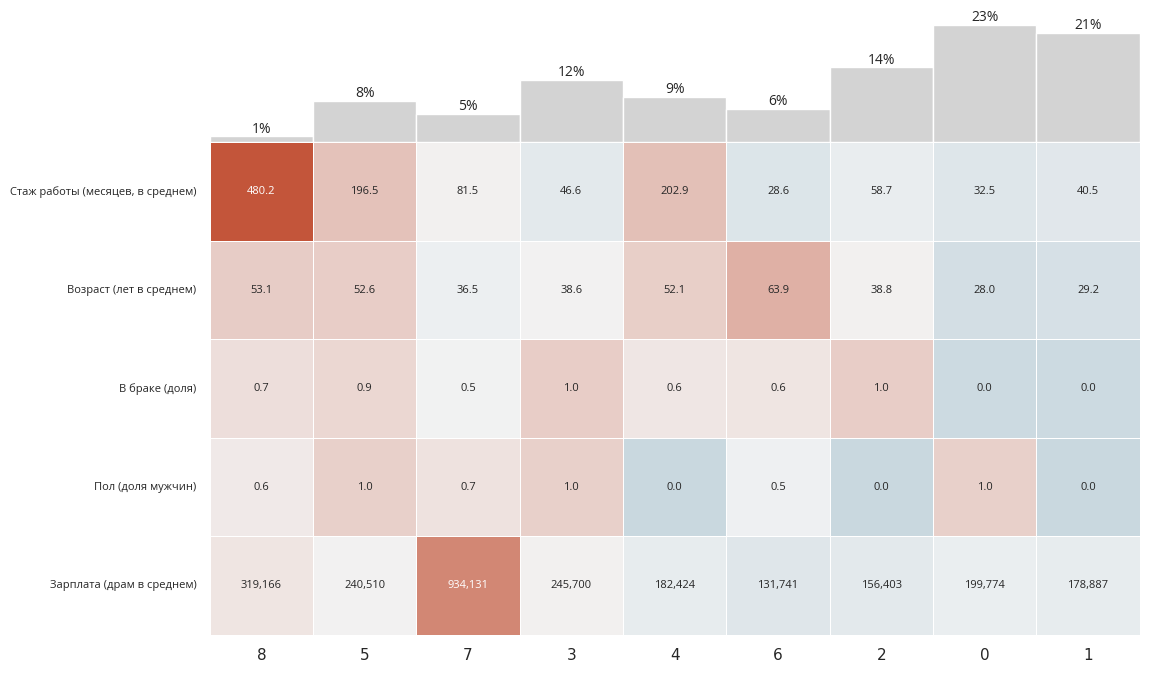

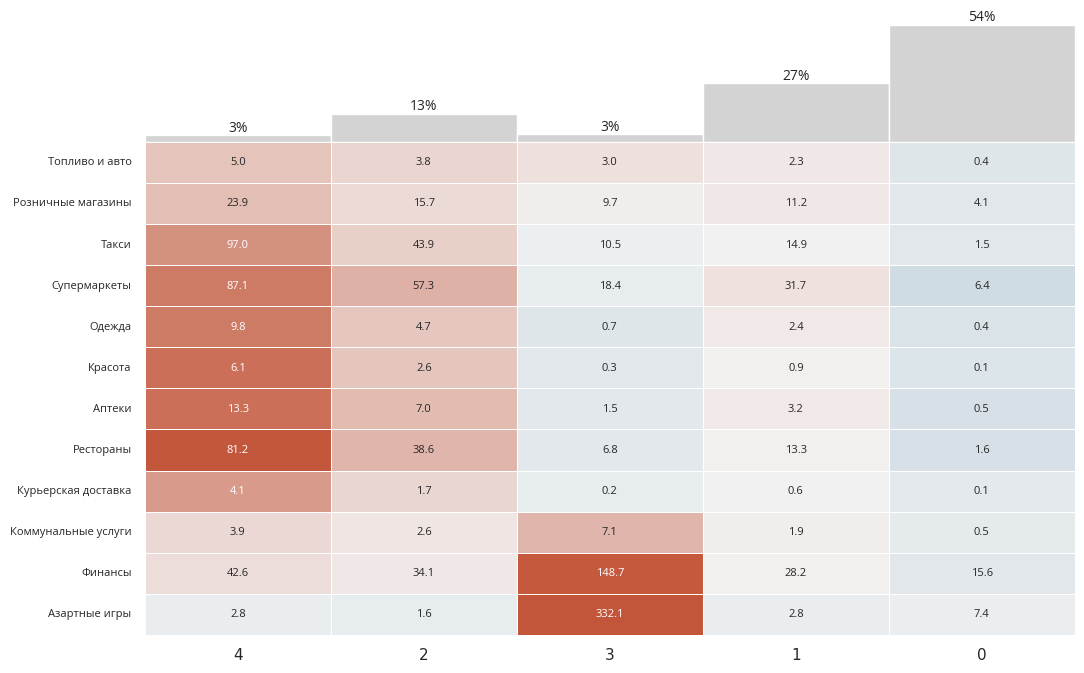

In [ ]:
with open('domains_pd.pkl', 'rb') as file:
    results_pd = pickle.load(file)

best_trials_dict, df_dict_pd, labels_dict_pd, best_params_dict, labels_series_dict_pd = results_pd

labels_series_dict_pd['trans'][labels_series_dict_pd['trans'] == 5] = 3

centers_dict = {
    'trans': 0,
    'behavioral': 0,
    'product': 0,
    'finance': 0,
    'personal': 0,
}

selected_feats = selected_domain_features.copy()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
for name, df in df_dict_pd.items():
    scaler = SklearnStandardScaler()
    scaler.fit(df)
    show_heatmap(df, labels_series_dict_pd[name], scaler=scaler, cmap=cmap, center=centers_dict[name])

### Get feature importance


CLUSTERING behavioral


CLUSTER 0



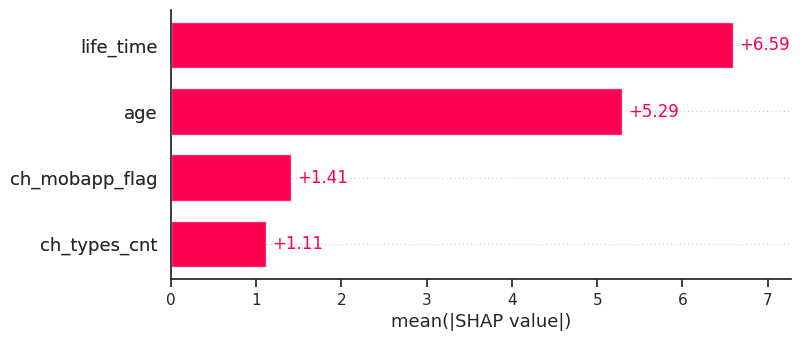

/content/drive/MyDrive/ameriabank/utils.py:328: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fi = pd.concat([all_fi, feature_importance])



CLUSTER 1



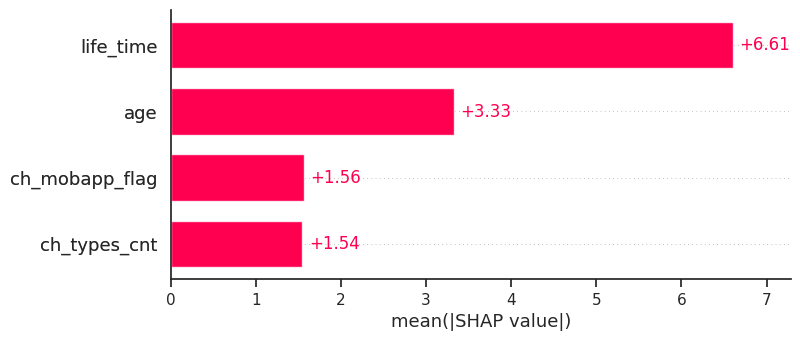


CLUSTER 2



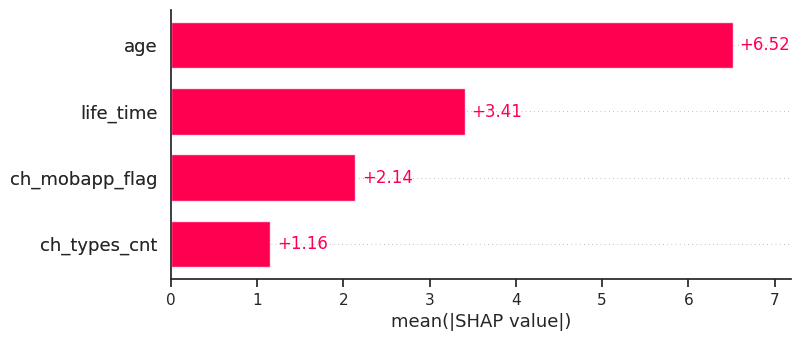


CLUSTER 3



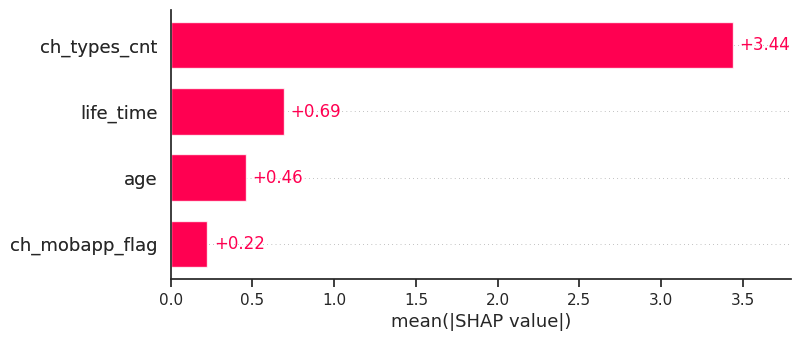


CLUSTER 4



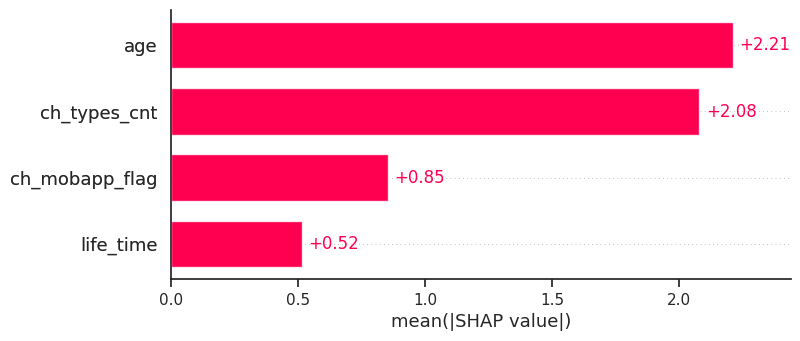


CLUSTER 5



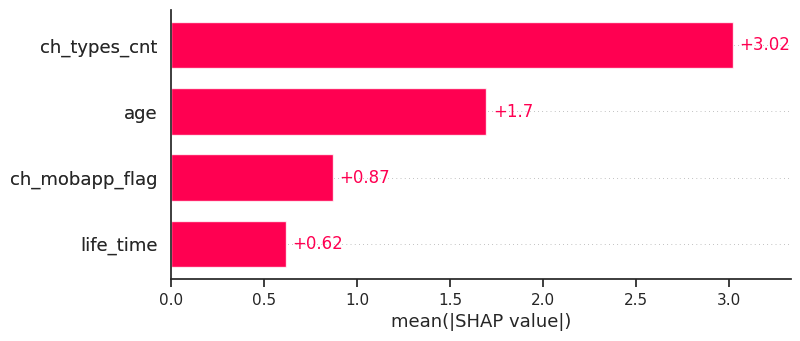


CLUSTER 6



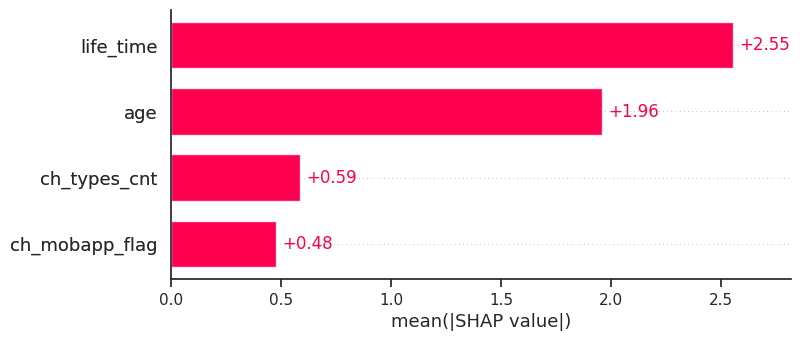


CLUSTER 7



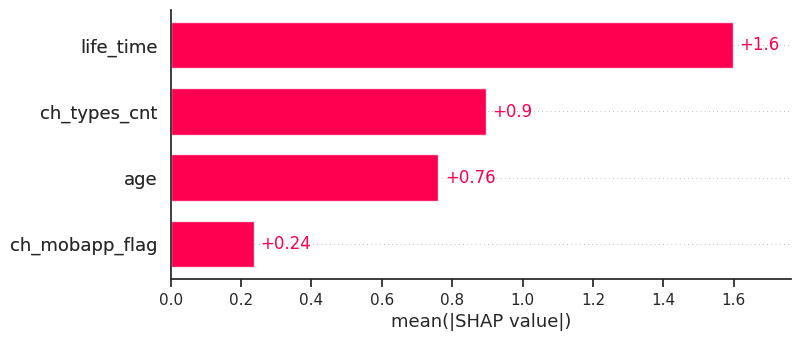


CLUSTER 8



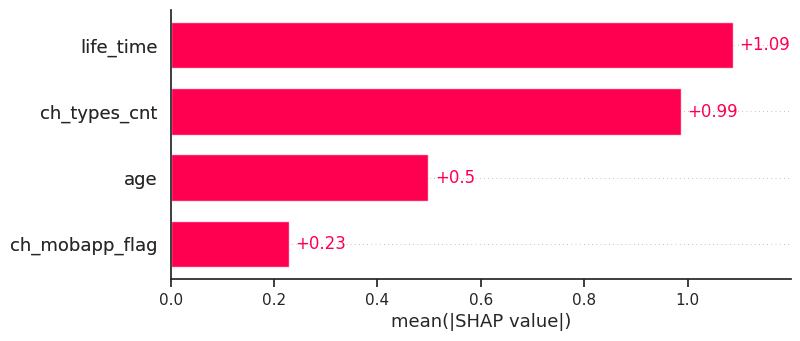


CLUSTER 9



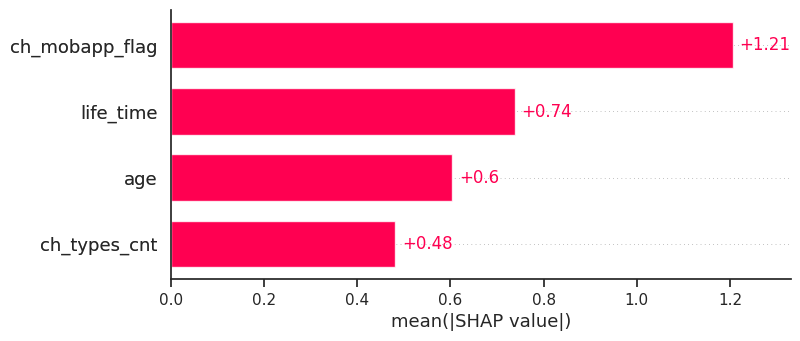


CLUSTER 10



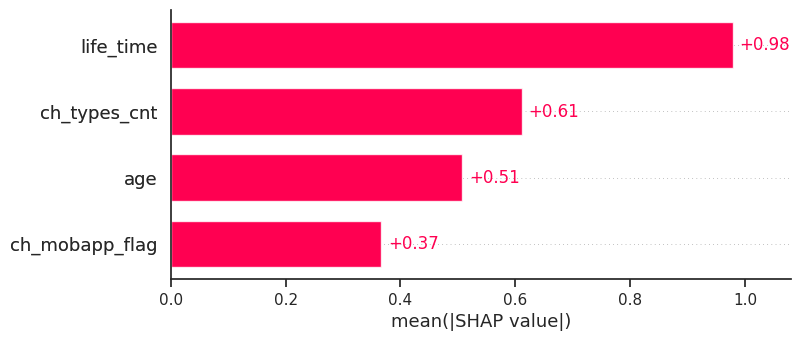


CLUSTERING product


CLUSTER 0



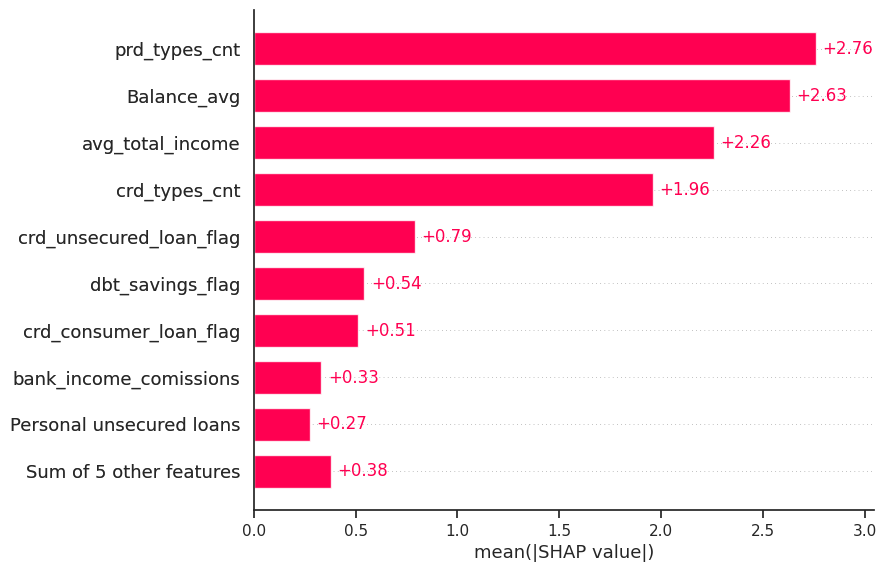


CLUSTER 1



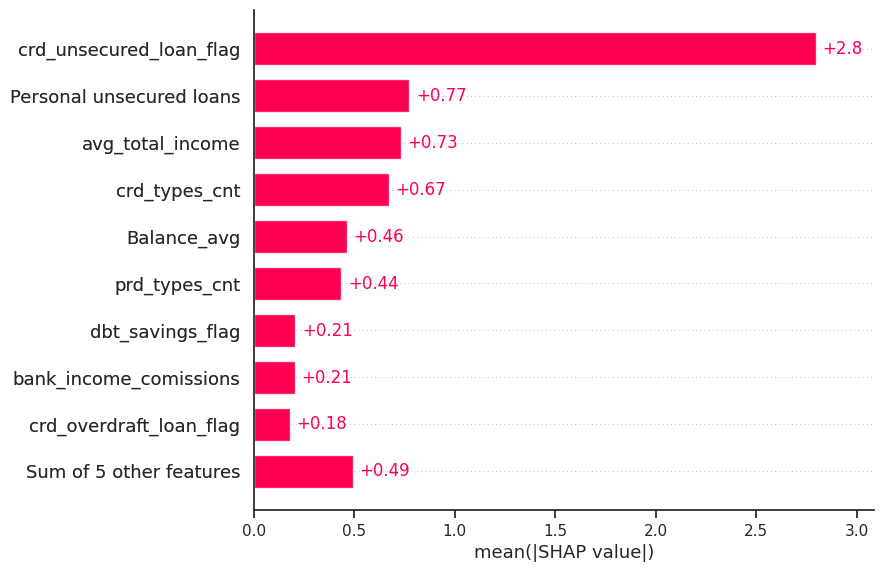


CLUSTER 2



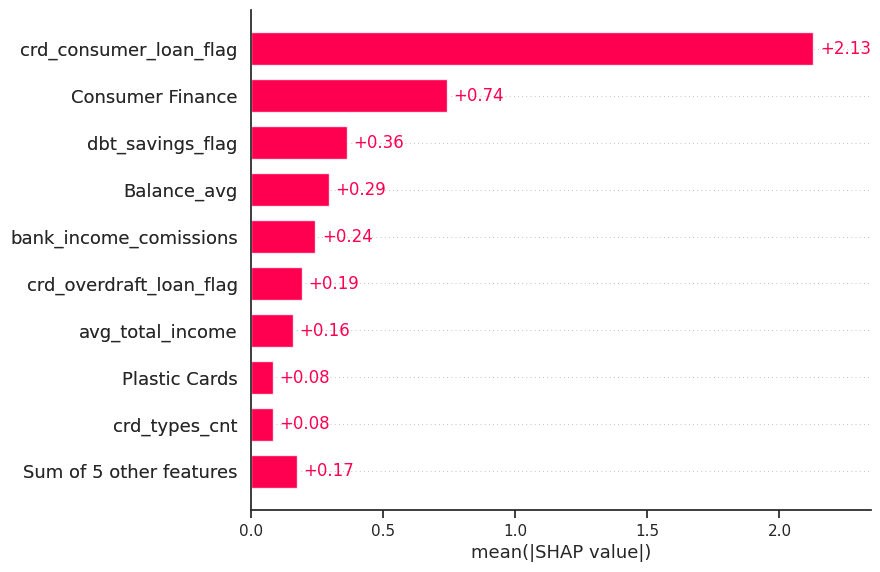


CLUSTER 3



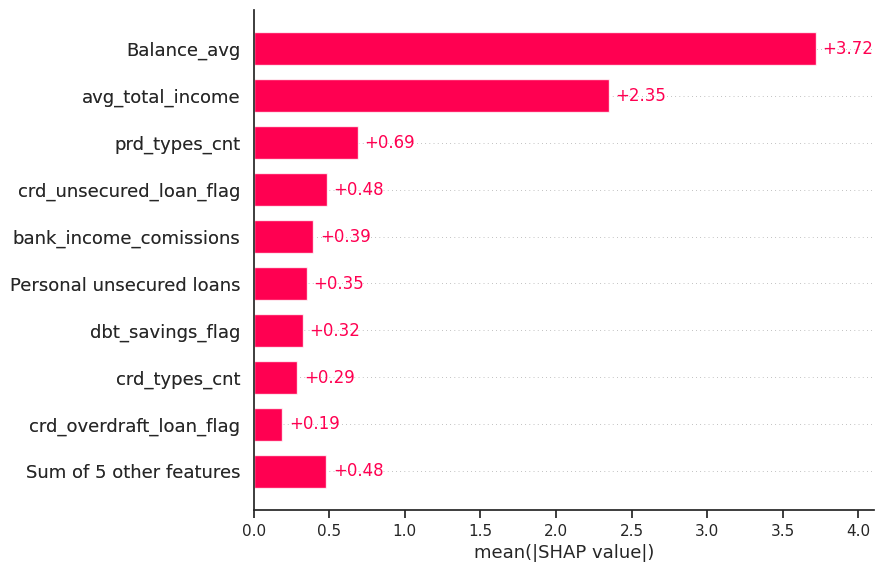


CLUSTER 4



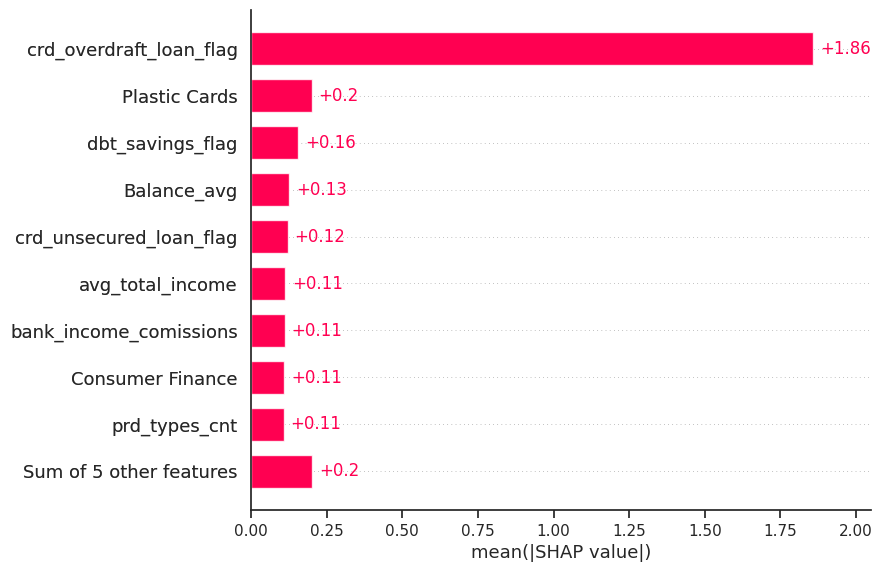


CLUSTER 5



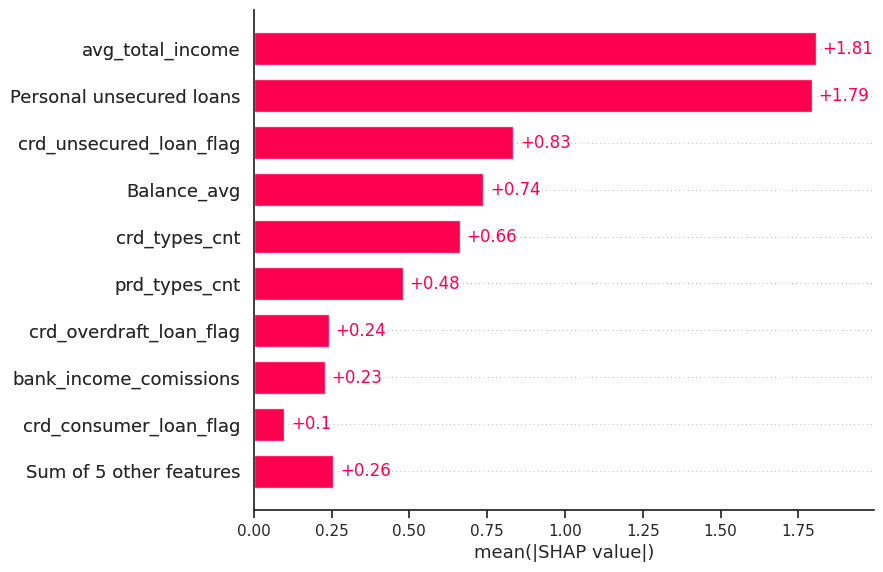


CLUSTER 6



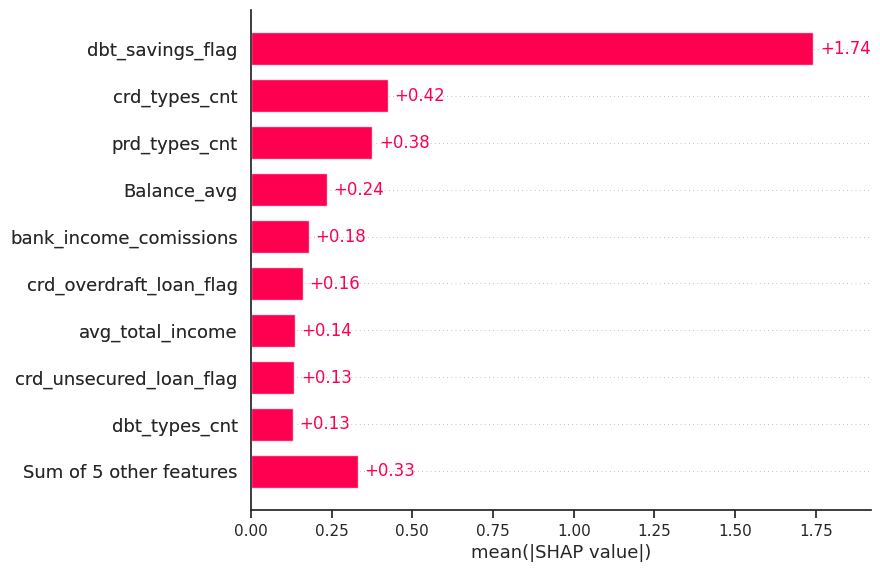


CLUSTER 7



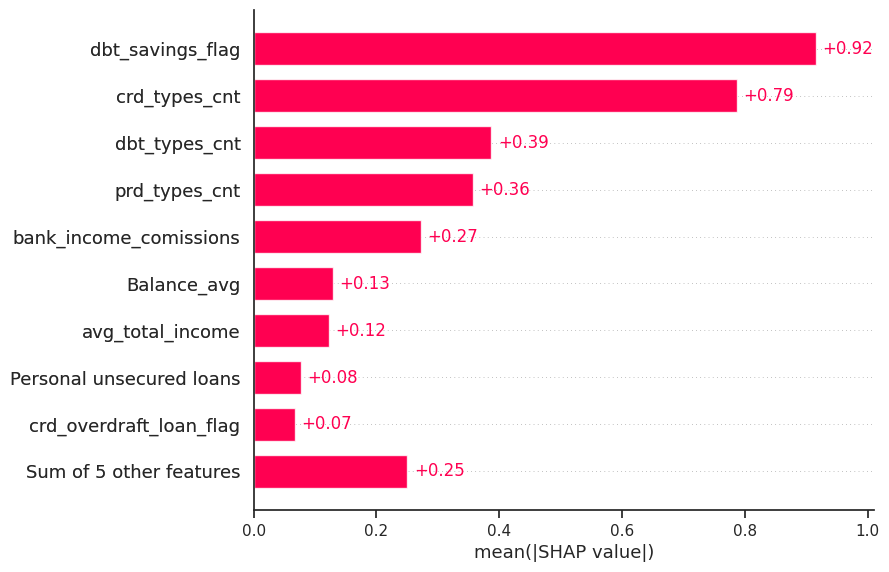


CLUSTER 8



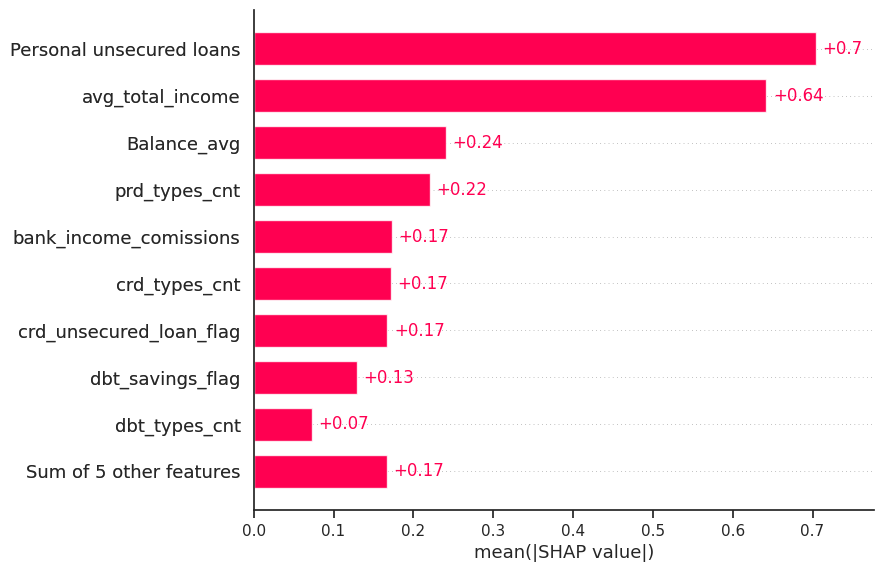


CLUSTER 9



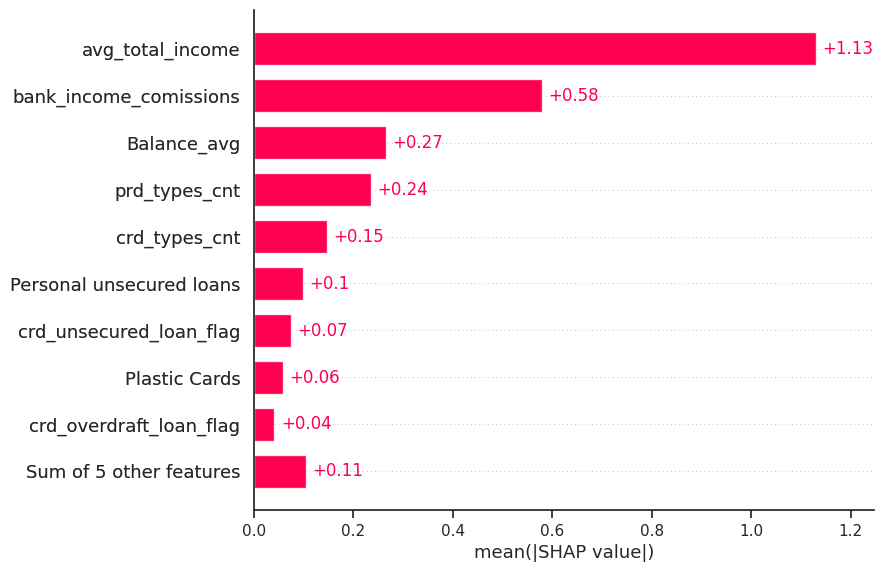


CLUSTER 10



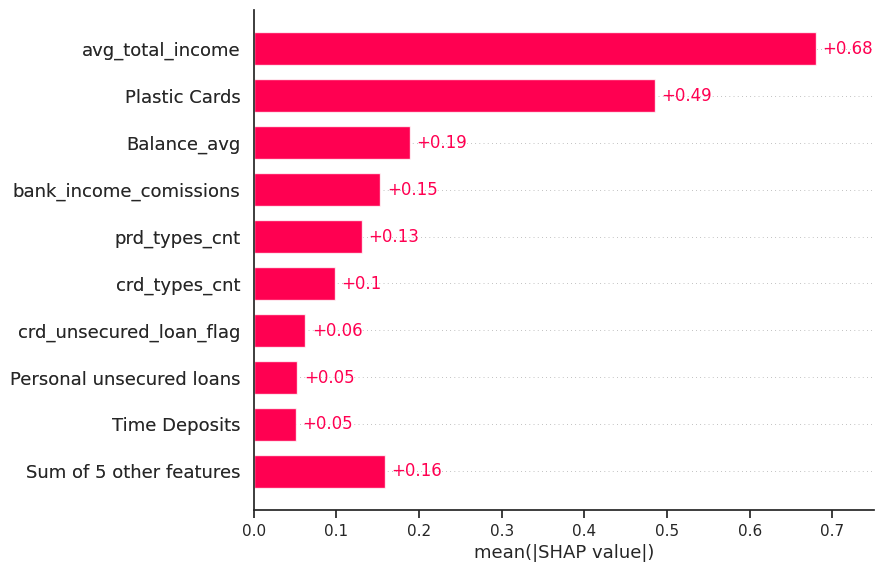


CLUSTER 11



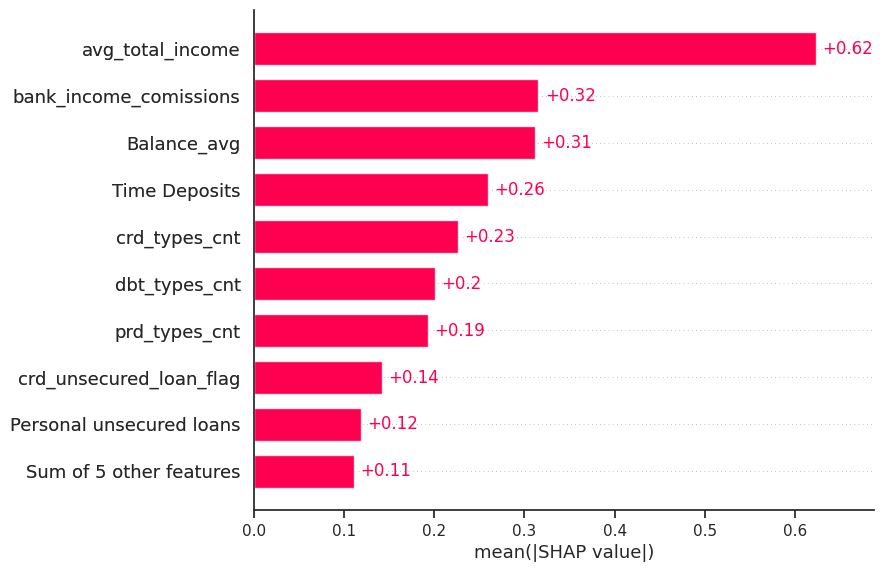


CLUSTERING finance


CLUSTER 0



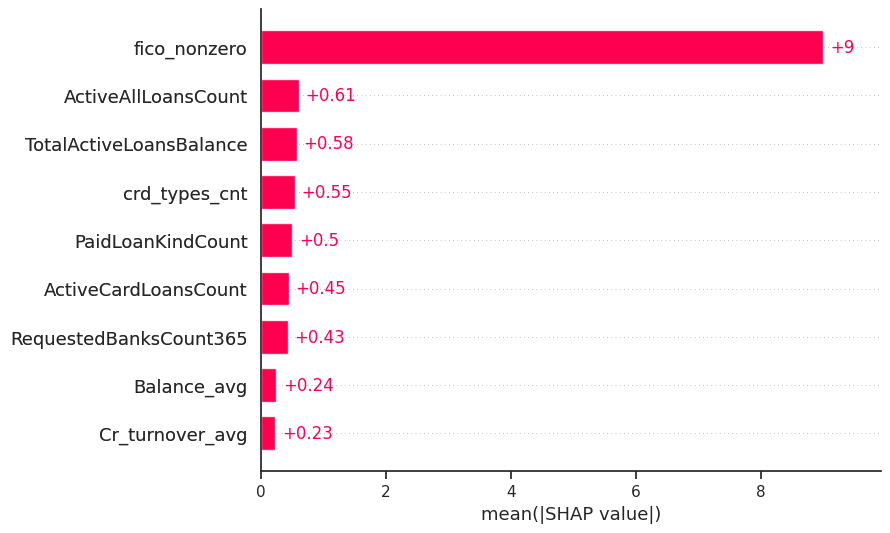


CLUSTER 1



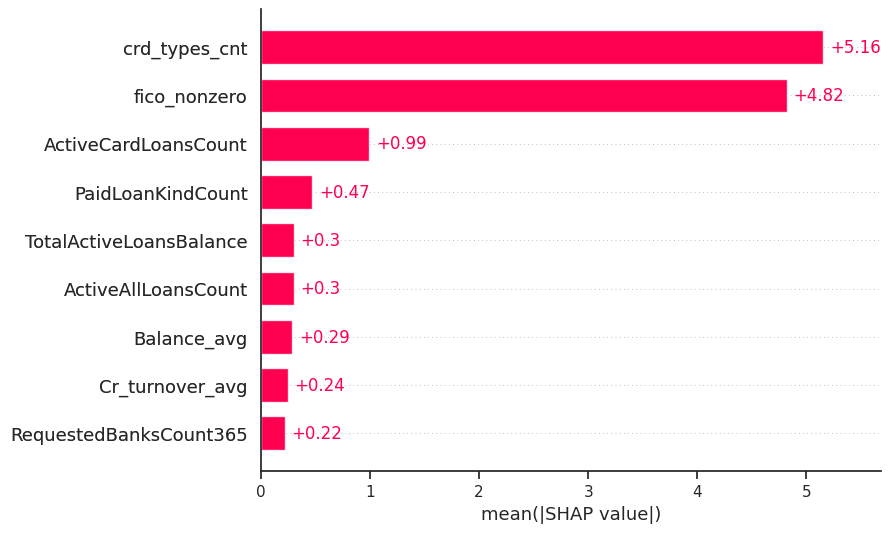


CLUSTER 2



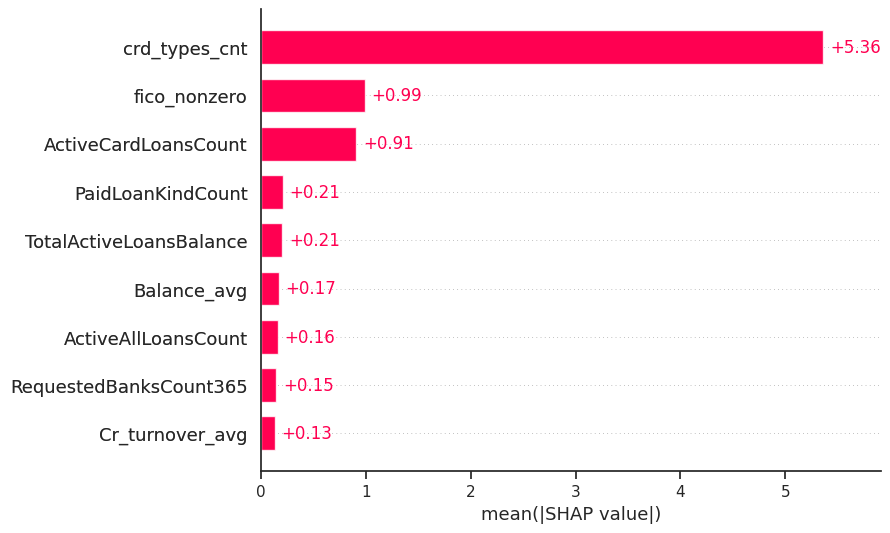


CLUSTER 3



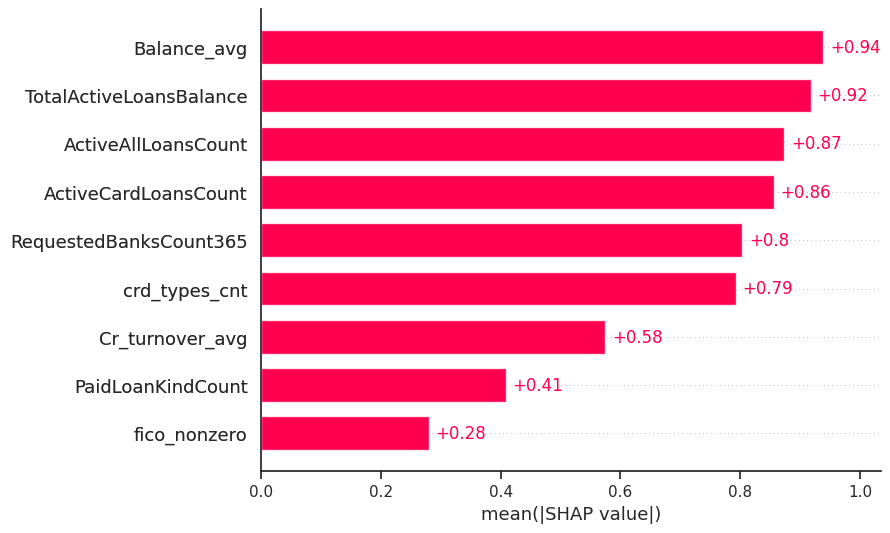


CLUSTER 4



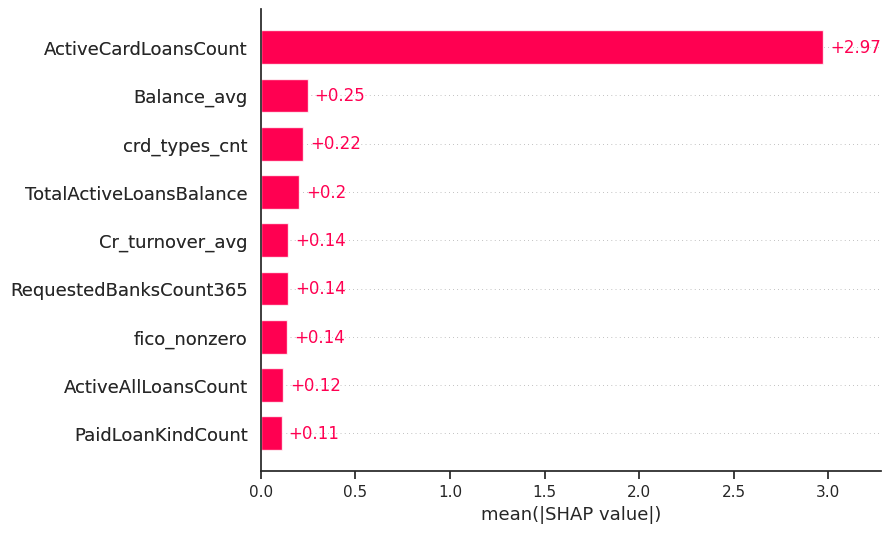


CLUSTERING personal


CLUSTER 0



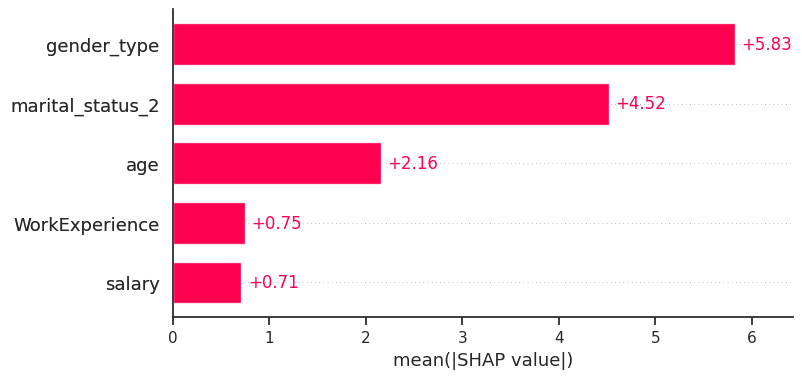


CLUSTER 1



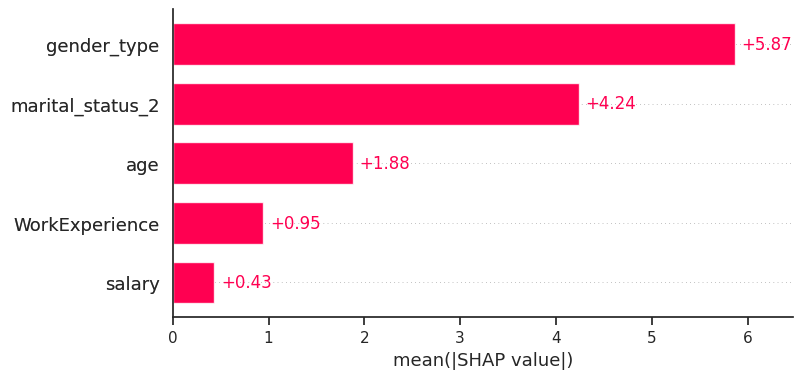


CLUSTER 2



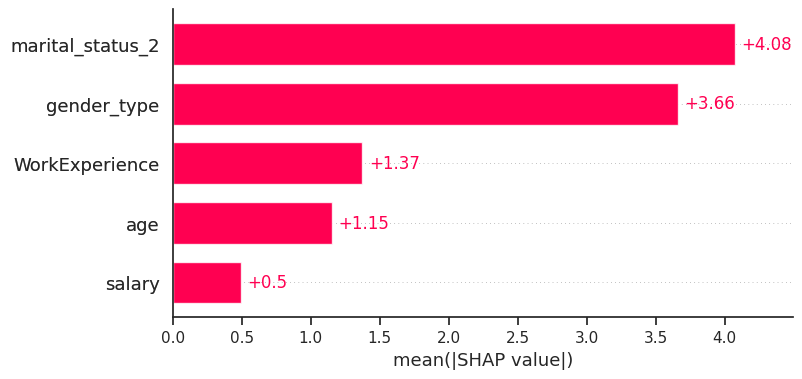


CLUSTER 3



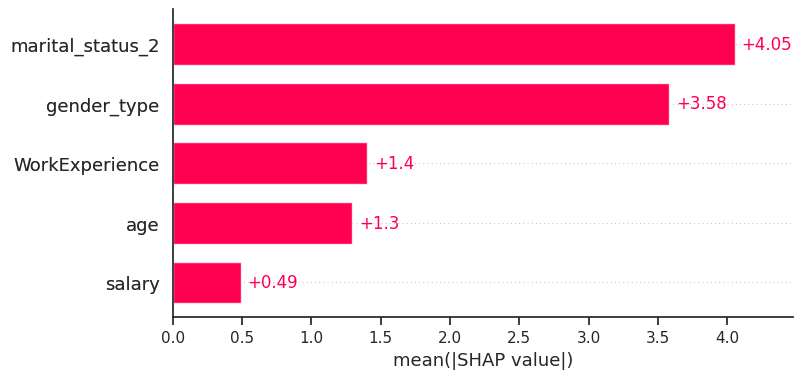


CLUSTER 4



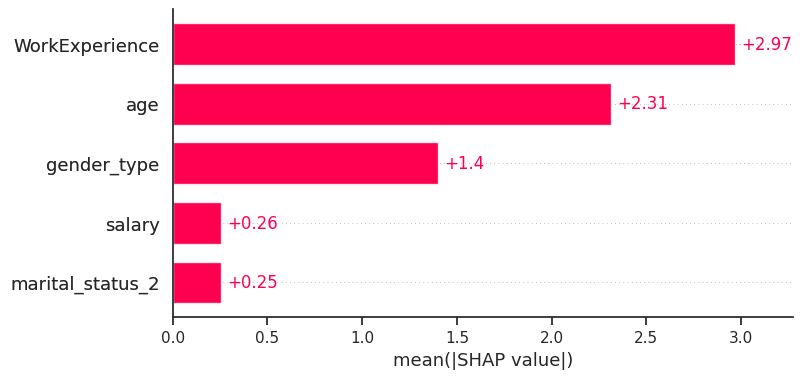


CLUSTER 5



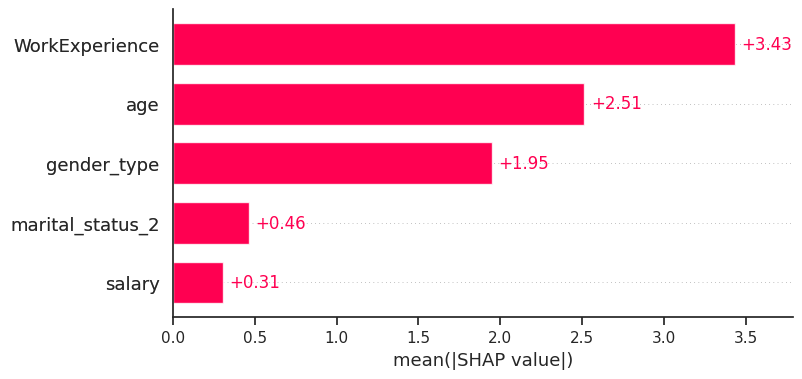


CLUSTER 6



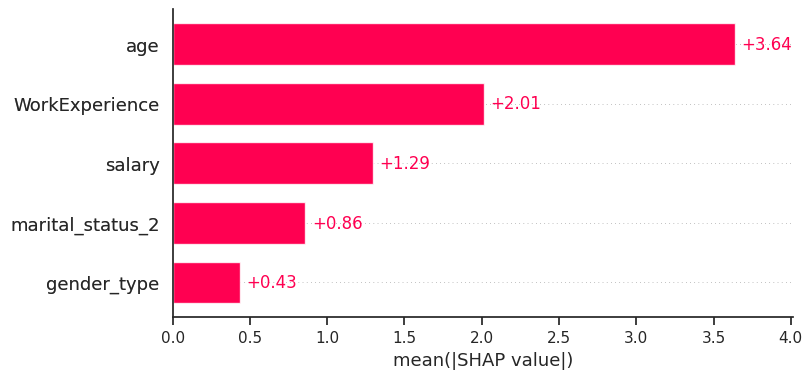


CLUSTER 7



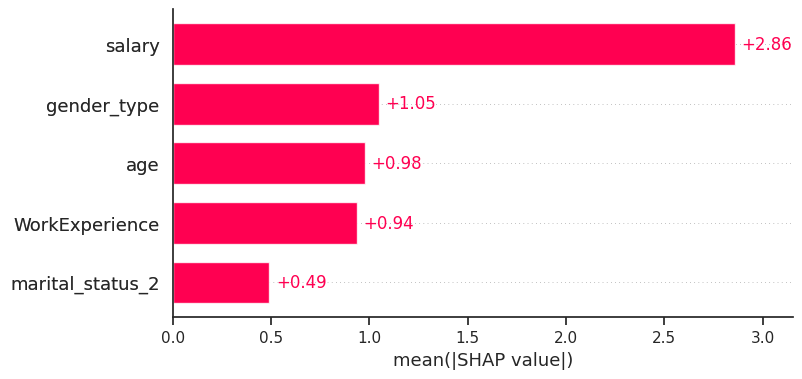


CLUSTER 8



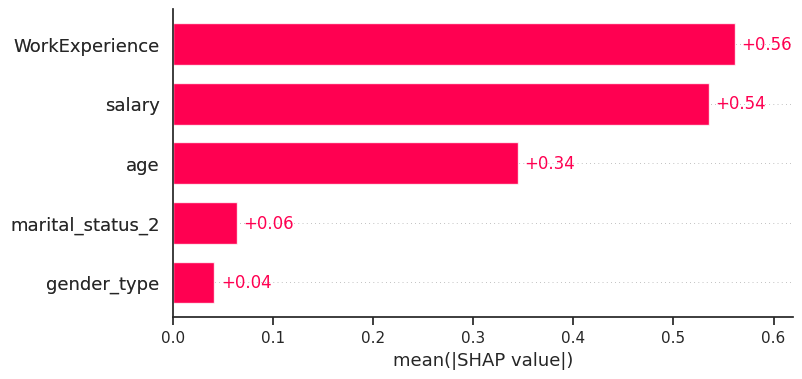


CLUSTERING trans


CLUSTER 0



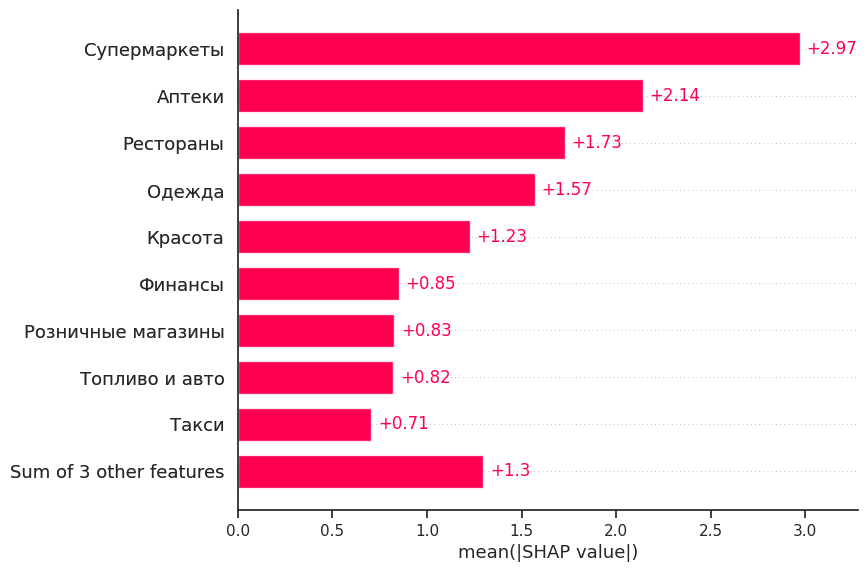


CLUSTER 1



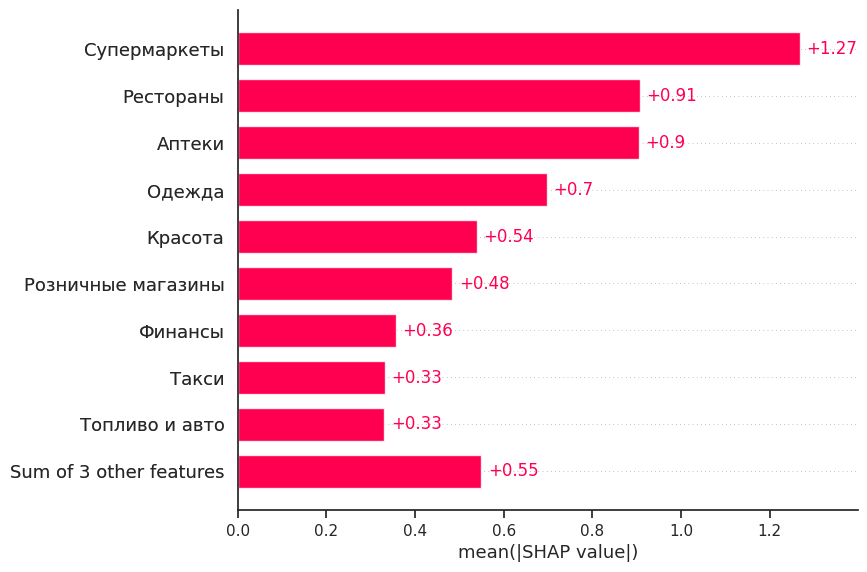


CLUSTER 2



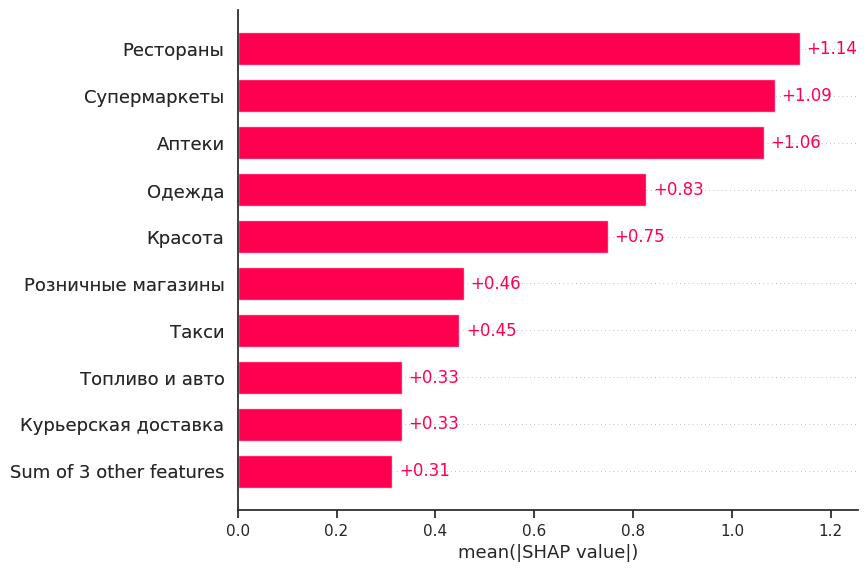


CLUSTER 3



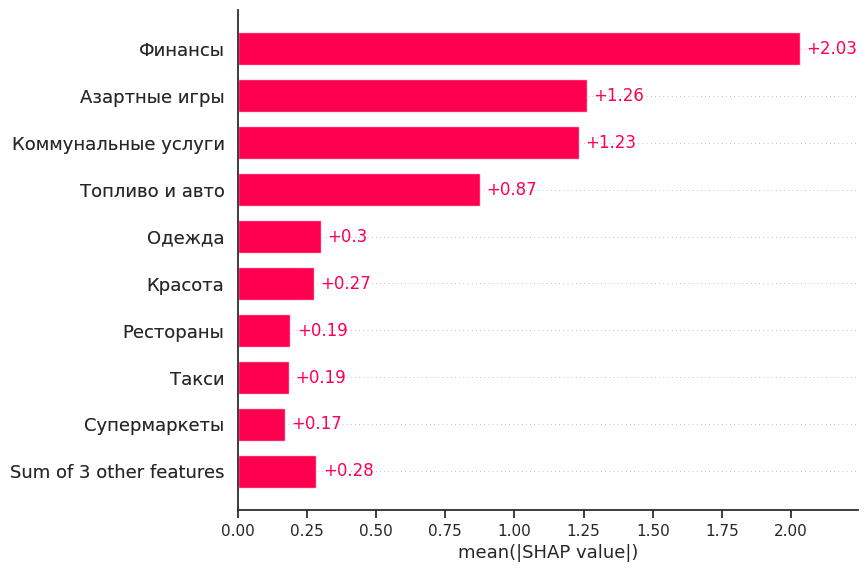


CLUSTER 4



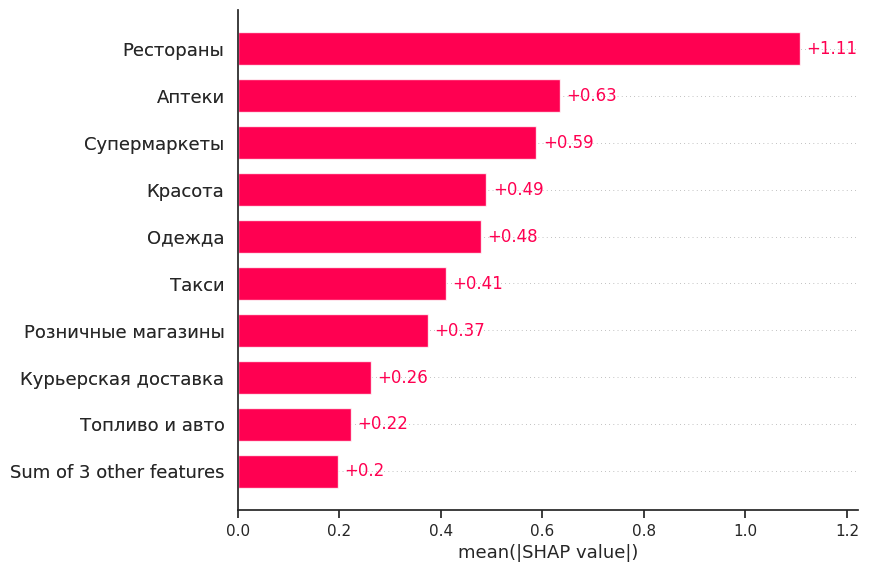

In [ ]:
from utils import get_shap_values

fi = get_shap_values(df_dict_pd, labels_series_dict_pd, local=True)

### KModes clustering for group1

#### Model

Now we may restart the kernel and proceed with CPU

In [ ]:
%%capture

from google.colab import drive
import sys
import os
import matplotlib.font_manager as fm

current_path = '/content/drive/MyDrive/ameriabank'

drive.mount('/content/drive')
sys.path.append(current_path)
os.chdir(current_path)

!pip install kmodes faiss-cpu catboost optuna

from utils_cpu import *

fm.fontManager.addfont('OpenSans[wdth,wght].ttf')
plt.rcParams['font.family'] = ['Open Sans']

In [ ]:
with open('domains_pd.pkl', 'rb') as file:
    results_pd = pickle.load(file)

best_trials_dict, df_dict_pd, labels_dict_pd, best_params_dict, labels_series_dict_pd = results_pd

labels_series_dict_pd['trans'][labels_series_dict_pd['trans'] == 5] = 3

df_feats_km = pd.concat(df_dict_pd.values(), axis=1, join='inner')
df_feats_km = df_feats_km.loc[:, ~df_feats_km.columns.duplicated(keep='last')]
df_labels_km = pd.concat(labels_series_dict_pd.values(), axis=1, join='inner')
trans_map = {
    0: 'Экономное потребление',
    1: 'Среднее потребление',
    2: 'Высокое потребление',
    3: 'Азартные',
    4: 'Премиальное потребление'
}
df_feats_km['tr'] = labels_series_dict_pd['trans'].map(trans_map)
df_feats_km = pd.get_dummies(df_feats_km, 'tr', dtype=int).drop(
    columns=[
        'Супермаркеты', 'Рестораны', 'Одежда', 'Аптеки', 'Красота', 'Финансы',
       'Такси', 'Курьерская доставка', 'Топливо и авто', 'Розничные магазины',
       'Коммунальные услуги', 'Азартные игры'
       ]
    )
df_labels_km.to_parquet('df_labels_km.parquet')

In [ ]:
df_labels_km

,0,1,2,3,4
CODE,,,,,
70845_1,0,3,0,7,2
84280_1,0,3,3,7,2
55128_1,2,3,0,7,0
13643_1,3,3,3,7,2
50017_1,1,7,3,7,2
...,...,...,...,...,...
61960_1,0,2,2,3,0
73393_1,0,0,0,0,0
56539_1,0,0,1,0,1


In [ ]:
from kmodes.kmodes import KModes

km = KModes(n_clusters=12, init='Huang', random_state=11, n_jobs=-1, verbose=2, n_init=5)
predicted_labels = km.fit_predict(df_labels_km)
predicted_labels = transform_labels(predicted_labels, df_labels_km.index)

df_feats_km.to_csv('feats_km.csv', encoding='utf-8-sig')
predicted_labels.to_csv('predicted_labels_km.csv')

Best run was number 4


#### Group 1 clusters visualisation

In [ ]:
final_feats = [
    'age',
    'gender_type',
    'marital_status_2',
    'WorkExperience',
    'life_time',

    'salary',
    'ch_mobapp_flag',
    'fico_nonzero',
    'RequestedBanksCount365',
    'ActiveAllLoansCount',
    'TotalActiveLoansBalance',

    'Balance_avg',

    'tr_Азартные',
    'tr_Экономное потребление',
    'tr_Среднее потребление',
    'tr_Высокое потребление',
    'tr_Премиальное потребление',

    'dbt_types_cnt',
    'crd_types_cnt',
    'prd_types_cnt',

    'Consumer Finance',
    'Personal unsecured loans',
    'Plastic Cards',
    'bank_income_comissions',
    'Time Deposits',
    'avg_total_income'
    ]

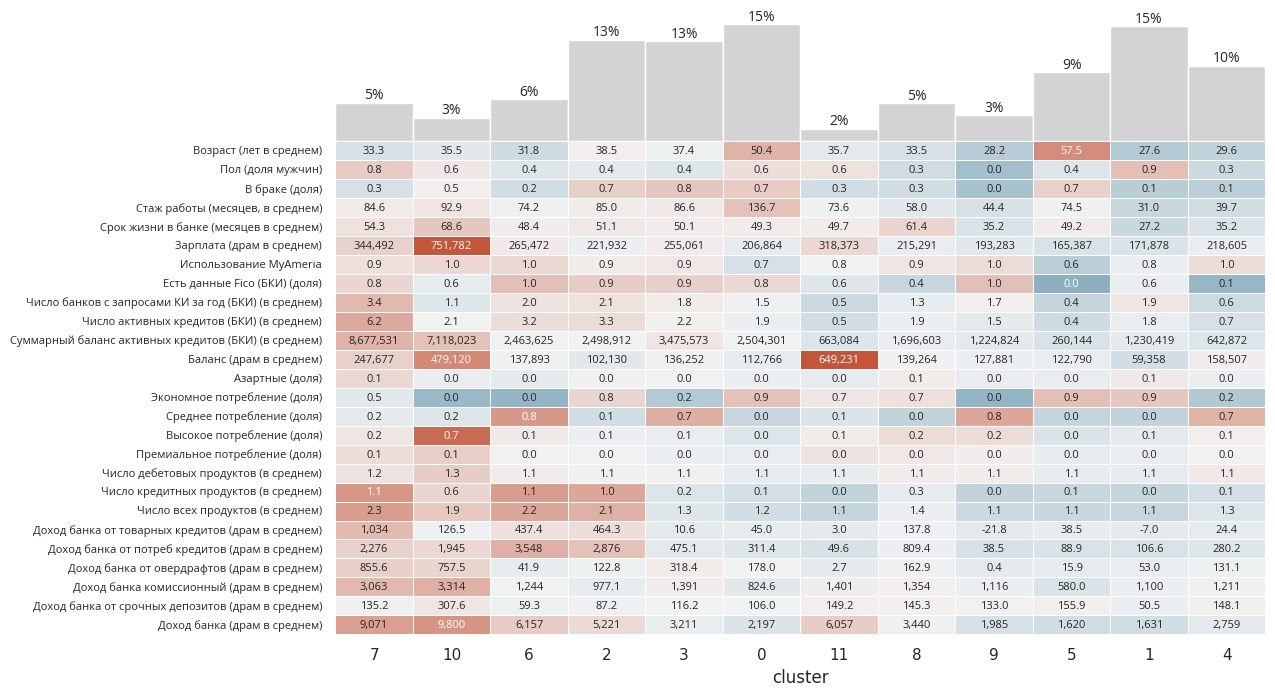

In [ ]:
df_feats_km = pd.read_csv('feats_km.csv').set_index('CODE')
cluster_labels = pd.read_csv('predicted_labels_km.csv').set_index('CODE')['cluster']

df_feats_km = df_feats_km[final_feats]

df_feats_km = df_feats_km.rename(columns={
    'tr_Экономное потребление': 'Экономное потребление (доля)',
    'tr_Среднее потребление': 'Среднее потребление (доля)',
    'tr_Высокое потребление': 'Высокое потребление (доля)',
    'tr_Премиальное потребление': 'Премиальное потребление (доля)',
    'tr_Азартные': 'Азартные (доля)'
})

cmap = sns.diverging_palette(230, 20, as_cmap=True)

scaler = SklearnStandardScaler()
scaler.fit(df_feats_km)
show_heatmap(
    df_feats_km,
    pd.Series(cluster_labels, df_feats_km.index),
    scaler=scaler,
    cols2drop=[],
    cols_dict=cols_dict,
    cmap=cmap,
    center=0,
    reorder_features=False
    )

# Similarity search for the rest of data (group 2 + group1 outliers)

### Data preprocessing

In [ ]:
%%time
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import pickle
import gc


pd.set_option("display.max_columns" , 500)
pd.set_option("display.max_rows" , 100)


# DATA G1

group1 = pd.read_excel('group1.xlsx').set_index('CODE').iloc[:, 1:]
colnames_dict = {c:c[:-2] for c in group1.columns if c.endswith('_x')}
colnames_dict.update({'lifr_time': 'life_time'})
cols2drop_y = [c for c in group1.columns if c.endswith('_y')]

data_g1 = group1.rename(columns=colnames_dict).drop(columns=cols2drop_y)
data_g1.index = data_g1.index.astype(str) + '_1'

data_g1[~data_g1.index.duplicated(keep='first')]

data_g1.to_parquet('data_g1.parquet')

# DATA G2

group2_inc = pd.read_excel('group2_inc.xlsx').set_index('CODE').iloc[:, :-2]
group2_inc.to_parquet('group2_inc.parquet')

Second_group_part1 = pd.read_excel('Second_group_part1.xlsx').drop(columns=group2_inc.columns).set_index('CODE').iloc[:, 1:]
Second_group_part1.to_parquet('Second_group_part1.parquet')

ACRA_for_second_group = pd.read_excel('ACRA_for_second_group.xlsx').set_index('CODE')
ACRA_for_second_group.to_parquet('ACRA_for_second_group.parquet')

norq2 = pd.read_excel('norq for second group.xlsx').set_index('CODE')
norq2.to_parquet('norq2.parquet')

feats_group2 = pd.read_excel('Clients Second Group avg_income_balance_turnover.xlsx').set_index('CODE')
feats_group2.to_parquet('feats_group2.parquet')

gc.collect()

CPU times: user 8min 46s, sys: 5.15 s, total: 8min 52s
Wall time: 9min 43s


149573

In [ ]:
data_g1 = pd.read_parquet('data_g1.parquet')
group2_inc = pd.read_parquet('group2_inc.parquet')
Second_group_part1 = pd.read_parquet('Second_group_part1.parquet')
ACRA_for_second_group = pd.read_parquet('ACRA_for_second_group.parquet')
norq2 = pd.read_parquet('norq2.parquet')
feats_group2 = pd.read_parquet('feats_group2.parquet')

data_g2 = pd.concat([group2_inc, Second_group_part1, ACRA_for_second_group, norq2, feats_group2], axis=1, join='inner').drop(columns=['Community', 'Region']).rename(
    columns={
        'AGE':'age', 'Total': 'avg_total_income','GENDER_TYPE': 'gender_type'
        }
    )
data_g2.index = data_g2.index.astype(str) + '_2'
data_g2[~data_g2.index.duplicated(keep='first')]

data_g2.to_parquet('data_g2.parquet')
data_g2 = pd.read_parquet('data_g2.parquet')

# DATA TOTAL

common_cols = [c for c in data_g1.columns if c in data_g2.columns]
df_total = pd.concat([data_g1[common_cols], data_g2[common_cols]])

df_total = df_total[~df_total.index.duplicated(keep='first')]

# df_total = df_total[df_total['Residence_AM'] == 1]

df_total.to_parquet('df_total.parquet')

In [ ]:
tr_cnt_total_gr2 = pd.read_parquet('tr_cnt_total_gr2.parquet')
tr_cnt_total_gr1 = pd.read_parquet('tr_cnt_total_gr1.parquet')

In [ ]:
tr_cnt_total_gr1.index = tr_cnt_total_gr1.index.astype(str) + '_1'
tr_cnt_total_gr2.index = tr_cnt_total_gr2.index.astype(str) + '_2'
common_cols = [c for c in tr_cnt_total_gr1.columns if c in tr_cnt_total_gr2.columns]

trans_total = pd.concat(
    [
        tr_cnt_total_gr1[common_cols], tr_cnt_total_gr2[common_cols]
        ]
    ).fillna(0)


# TRANS PREPROC

mcc_groups = {
    'Супермаркеты': ['5411', '5499'],
    'Рестораны': ['5811', '5812', '5813', '5814', '5462'],
    'Одежда': ['5651', '5691'],
    'Аптеки': ['5912'],
    'Красота': ['5977', '7230'],
    'Финансы': ['6011', '6012', '6051', '6536', '4829'],
    'Такси': ['4121'],
    'Курьерская доставка': ['4215'],
    'Топливо и авто': ['5172', '5533', '5541', '5983'],
    'Розничные магазины': ['5200', '5311', '5331', '5399', '5999', '5039', '5722'],
    'Коммунальные услуги': ['4900'],
    'Азартные игры': ['7995']
}

for k, v in mcc_groups.items():
    trans_total[k] = trans_total[v].sum(axis=1)
trans_total = trans_total[list(mcc_groups.keys())]


trans_total.to_parquet('trans_total.parquet')

In [ ]:
data_g1 = pd.read_parquet('data_g1.parquet')
data_g2 = pd.read_parquet('data_g2.parquet')
data = pd.read_parquet('df_total.parquet')
data = data[~data.index.duplicated(keep='first')]


tr_cnt_total_gr2 = pd.read_parquet('tr_cnt_total_gr2.parquet')
tr_cnt_total_gr1 = pd.read_parquet('tr_cnt_total_gr1.parquet')

tr_cnt_total_gr1.index = tr_cnt_total_gr1.index.astype(str) + '_1'
tr_cnt_total_gr2.index = tr_cnt_total_gr2.index.astype(str) + '_2'

trans_total = pd.read_parquet('trans_total.parquet')

In [ ]:
data

,Average_Income,age,gender_type,life_time,SwitchisClassQuantity,TheWorstClassLoan,RequestQuantity30,RequestQuantity365,TheWorsClassGuarantee,RequestedBanksCount365,...,prMortgage Loans,prMy Ameria,prPersonal secured loans,prPersonal unsecured loans / Manual,prPersonal unsecured loans / Scoring,prPhone banking,prPlastic Cards / Manual,prPlastic Cards / Scoring,prSME Loans / Manual,prSaving account
CODE,,,,,,,,,,,,,,,,,,,,,
85477_1,1.772221e+08,39,1,14,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
17102_1,1.215950e+08,39,1,84,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5336_1,1.121741e+08,32,0,139,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
31595_1,1.033733e+08,27,1,64,0,6,2,18,0,2,...,0,1,0,0,5,0,0,1,0,0
11436_1,8.450092e+07,31,1,107,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696_2,NaN,34,3,3,1,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
11856_2,4.710000e+04,67,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11910_2,1.314840e+05,30,3,3,2,3,0,22,7,2,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
trans_total

,Супермаркеты,Рестораны,Одежда,Аптеки,Красота,Финансы,Такси,Курьерская доставка,Топливо и авто,Розничные магазины,Коммунальные услуги,Азартные игры
CODE,,,,,,,,,,,,
0_1,1.0,1.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
1_1,16.0,11.0,0.0,1.0,1.0,55.0,19.0,0.0,0.0,9.0,8.0,0.0
2_1,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,1.0,1.0,0.0,104.0
3_1,43.0,21.0,2.0,2.0,0.0,32.0,11.0,0.0,0.0,1.0,0.0,0.0
4_1,85.0,35.0,2.0,2.0,0.0,42.0,19.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149456_2,1.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0
149457_2,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,40.0
149458_2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data['salary'] = np.where(
    data['Average_Income'] > 0, data['Average_Income'],
    np.where(
        data['Salary'] > 0, data['Salary'], 0)).astype(int)

outlier_cols = ['salary', 'Balance_avg', 'avg_total_income']
outliers_g2_ix = get_outliers_ix(data.loc[data.index.str.contains('_2')], outlier_cols)

data = pd.get_dummies(data,
                        columns=['MARITAL_STATUS'],
                        prefix=['marital_status'],
                        dtype=int)
data['crd_car_loan_cnt'] = data['prCar Loans / Manual'] + data['prCar Loans / Scoring']
data['crd_unsecured_loan_cnt'] = data['prPersonal unsecured loans / Manual'] + data['prPersonal unsecured loans / Scoring']
data['crd_overdraft_loan_cnt'] = data['prPlastic Cards / Manual'] + data['prPlastic Cards / Scoring']

col_rename_dict = {
    'prConsumer Finance': 'crd_consumer_loan_cnt',
    'prFinancial leasing': 'crd_leasing_loan_cnt',
    'prGold Collatoralised Loans': 'crd_gold_loan_cnt',
    'prGuaranties': 'crd_guarantee_cnt',
    'prInvestment loans': 'crd_invest_loan_cnt',
    'prMortgage Loans': 'crd_mortgage_loan_cnt',
    'prPersonal secured loans': 'crd_secured_loan_cnt',
    'prSME Loans / Manual': 'crd_sme_loan_cnt',
    'prBond': 'dbt_bond_cnt',
    'prCard': 'dbt_paycard_cnt',
    'prDeposit box': 'dbt_depositbox_cnt',
    'prDeposit': 'dbt_deposit_cnt',
    'prMetal account': 'dbt_metal_cnt',
    'prOther Assets': 'dbt_other_cnt',
    'prSaving account': 'dbt_savings_cnt',
    'prInternet banking': 'ch_ibank_cnt',
    'prMy Ameria': 'ch_mobapp_cnt',
    'prPhone banking': 'ch_smsbank_cnt'
    }
data = data.rename(columns=col_rename_dict)
pr_cols = [col for col in data.columns if col.startswith('pr')]
data = data.drop(columns=pr_cols)

cnt_cols = [col for col in data.columns if col.endswith("_cnt")]
for col in cnt_cols:
    data[f'{col[:-3]}flag'] = (data[col]>0)*1

crd_flag_cols = [col for col in data.columns if col.startswith('crd_') and col.endswith('_flag')]
dbt_flag_cols = [col for col in data.columns if col.startswith('dbt_') and col.endswith('_flag')]
ch_flag_cols = [col for col in data.columns if col.startswith('ch_') and col.endswith('_flag')]

data['crd_types_cnt'] = data[crd_flag_cols].sum(axis=1).astype('int8')
data['dbt_types_cnt'] = data[dbt_flag_cols].sum(axis=1).astype('int8')
data['prd_types_cnt'] = data['crd_types_cnt'] + data['dbt_types_cnt']
data['ch_types_cnt'] = data[ch_flag_cols].sum(axis=1).astype('int8')

data['bank_income_comissions'] = data[
    ['Commission from transfers', 'Commissions from Cards', 'Other Commissions', 'Cash-non cash commission']
    ].sum(axis=1)

data['dbt_paycard_above2'] = (data['dbt_paycard_cnt']>2)*1
data['dbt_savings_above2'] = (data['dbt_savings_cnt']>2)*1

data['fico_nonzero'] = (data['FICOScore'] > 0)*1

### Data transform

In [ ]:
feature_types = get_feature_types(data)

features2keep = feature_types['binary']
features2log = [
    'life_time',
    'Consumer Finance',
    'Mortgage Loans',
    'Mortgage Loans',
    'Personal unsecured loans',
    'Plastic Cards',
    'Demand Deposits',
    'Time Deposits',
    'FX Income',
    'avg_total_income',
    'Balance_avg',
    'Cr_turnover_avg'
    ] + feature_types['discrete']

features2pt = [
    'age',
    'RequestQuantity365',
    'RequestedBanksCount365',
    'PaidLoansCount',
    'ActiveAllLoansCount',
    'MaxLoanAmount',
    'TotalActiveLoansBalance',
    'WorkExperience',
    'salary',
    'bank_income_comissions'
]

df_transformed = power_transform_features(data, features2pt)
df_logged = log_features(data, features2log)

data_transformed = pd.concat(
    [data[features2keep], df_transformed, df_logged], axis=1, join='inner')

data_transformed = data_transformed.astype({
    'crd_types_cnt': 'float32',
    'dbt_types_cnt': 'float32',
    'prd_types_cnt': 'float32',
    'ch_types_cnt': 'float32'
    })

data_transformed.to_parquet('data_transformed.parquet')

### Faiss setup

In [ ]:
selected_feats = selected_domain_features.copy()

data_transformed = pd.read_parquet('data_transformed.parquet')
data_transformed = data_transformed[~data_transformed.index.duplicated(keep='first')]

with open(f'domains_pd.pkl', 'rb') as file:
    results = pickle.load(file)

best_trials_dict, df_dict, labels_dict, best_params_dict, labels_series_dict = results


array_ix = data_transformed.index.values.astype(str)
mask_gr1 = np.char.find(array_ix, '_1') >= 0
mask_gr2 = np.char.find(array_ix, '_2') >= 0
ix_labeled = labels_series_dict['product'].index

gr1_unlabeled_ix = pd.Index(array_ix[mask_gr1]).difference(pd.Index(ix_labeled))
gr2_unlabeled_ix = pd.Index(array_ix[mask_gr2])

features_labeled = data_transformed.loc[ix_labeled]
features_unlabeled_gr1 = data_transformed.loc[gr1_unlabeled_ix]
features_unlabeled_gr2 = data_transformed.loc[gr2_unlabeled_ix]


### Nearest neighbours for the features

In [ ]:
from tqdm import tqdm
import faiss

nearest_labels_g1_dict = {}

for name in tqdm(labels_series_dict):
    if name != 'trans':
        l, i = get_faiss_labels(features_labeled, features_unlabeled_gr1, selected_feats, labels_series_dict, name)
        nearest_labels_g1_dict[name] = pd.DataFrame(l, index=features_unlabeled_gr1.index)

nearest_labels_g2_dict = {}

for name in tqdm(labels_series_dict):
    if name != 'trans':
        l, i = get_faiss_labels(features_labeled, features_unlabeled_gr2, selected_feats, labels_series_dict, name)
        nearest_labels_g2_dict[name] = pd.DataFrame(l, index=features_unlabeled_gr2.index)

with open('nearest_labels_g1_dict.pkl', 'wb') as file:
    pickle.dump(nearest_labels_g1_dict, file)
with open('nearest_labels_g2_dict.pkl', 'wb') as file:
    pickle.dump(nearest_labels_g2_dict, file)

100%|██████████| 5/5 [03:29<00:00, 41.97s/it]


In [ ]:
with open('nearest_labels_g1_dict.pkl', 'rb') as file:
    nearest_labels_g1_dict = pickle.load(file)
with open('nearest_labels_g2_dict.pkl', 'rb') as file:
    nearest_labels_g2_dict = pickle.load(file)

In [ ]:
nearest_labels_g1_dict

{'behavioral':          0  1  2  3  4
 10004_1  6  6  6  6  6
 10005_1  7  7  7  7  7
 10006_1  6  6  6  6  6
 10007_1  7  7  7  7  7
 10009_1  1  1  1  1  1
 ...     .. .. .. .. ..
 997_1    7  7  7  7  7
 9981_1   7  7  7  7  7
 9988_1   7  7  7  7  7
 998_1    7  7  7  7  7
 9992_1   1  1  1  1  1
 
 [14898 rows x 5 columns],
 'product':           0   1   2   3   4
 10004_1   8   8   8   8   5
 10005_1   3   3   3   3   3
 10006_1   3   3   3   3   3
 10007_1   7   7  11   7   7
 10009_1   9   9   9   9   9
 ...      ..  ..  ..  ..  ..
 997_1    10   7   7   7  10
 9981_1    4   4   4   4   4
 9988_1    6   6   9   9   9
 998_1     6   6   6   6   6
 9992_1   10  10  10  10  10
 
 [14898 rows x 5 columns],
 'finance':          0  1  2  3  4
 10004_1  3  3  3  3  3
 10005_1  3  3  0  3  0
 10006_1  0  0  0  0  0
 10007_1  3  3  3  3  3
 10009_1  3  3  3  3  3
 ...     .. .. .. .. ..
 997_1    3  3  3  3  3
 9981_1   3  3  3  3  3
 9988_1   3  3  3  3  3
 998_1    0  0  0  0  0
 9992_

In [ ]:
nearest_labels_g2_dict

{'behavioral':           0  1  2  3  4
 141947_2  0  0  0  0  0
 8713_2    0  0  0  0  0
 95421_2   0  0  0  0  0
 39182_2   3  3  3  3  3
 36787_2   1  1  1  1  1
 ...      .. .. .. .. ..
 11696_2   5  5  5  5  5
 11856_2   4  4  4  4  4
 11910_2   0  0  0  0  0
 12198_2   0  0  0  0  0
 12220_2   0  0  0  0  0
 
 [149462 rows x 5 columns],
 'product':           0  1   2  3  4
 141947_2  7  7   7  7  7
 8713_2    0  0   0  0  0
 95421_2   0  0   0  0  0
 39182_2   9  9  10  9  9
 36787_2   3  3   3  3  3
 ...      .. ..  .. .. ..
 11696_2   0  0   0  0  0
 11856_2   0  0   0  0  0
 11910_2   0  0   0  0  0
 12198_2   0  0   0  0  0
 12220_2   0  0   0  0  3
 
 [149462 rows x 5 columns],
 'finance':           0  1  2  3  4
 141947_2  2  2  2  2  2
 8713_2    0  0  0  0  0
 95421_2   0  0  0  0  0
 39182_2   3  3  3  3  3
 36787_2   1  1  1  1  1
 ...      .. .. .. .. ..
 11696_2   1  1  1  1  1
 11856_2   0  0  0  0  0
 11910_2   1  1  1  1  1
 12198_2   0  0  0  0  0
 12220_2   0  0  

### Nearest neighbours for transactions

In [ ]:
%%time

with open('domains_pd.pkl', 'rb') as file:
    results = pickle.load(file)

best_trials_dict, df_dict, labels_dict, best_params_dict, labels_series_dict = results
labels_series_dict['trans'][labels_series_dict['trans'] == 5] = 3
trans_labels = labels_series_dict['trans']

trans_total = trans_total[~trans_total.index.duplicated(keep='first')]

trans_array_ix = trans_total.index.values.astype(str)
trans_mask_gr1 = np.char.find(trans_array_ix, '_1') >= 0
trans_mask_gr2 = np.char.find(trans_array_ix, '_2') >= 0
trans_ix_labeled = trans_labels.index

trans_gr1_unlabeled_ix = pd.Index(trans_array_ix[trans_mask_gr1]).difference(pd.Index(trans_ix_labeled))
trans_gr2_unlabeled_ix = pd.Index(trans_array_ix[trans_mask_gr2])

trans_features_labeled = trans_total.loc[trans_ix_labeled]
trans_features_unlabeled_gr1 = trans_total.loc[trans_gr1_unlabeled_ix]
trans_features_unlabeled_gr2 = trans_total.loc[trans_gr2_unlabeled_ix]

trans_cols_dict = {}
trans_cols_dict['trans'] = trans_total.columns

l, i = get_faiss_labels(trans_features_labeled, trans_features_unlabeled_gr1, trans_cols_dict, labels_series_dict, 'trans')
trans_nearest_labels_g1 = pd.DataFrame(l, index=trans_features_unlabeled_gr1.index)
l, i = get_faiss_labels(trans_features_labeled, trans_features_unlabeled_gr2, trans_cols_dict, labels_series_dict, 'trans')
trans_nearest_labels_g2 = pd.DataFrame(l, index=trans_features_unlabeled_gr2.index)

with open('trans_nearest_labels_g1.pkl', 'wb') as file:
    pickle.dump(trans_nearest_labels_g1, file)
with open('trans_nearest_labels_g2.pkl', 'wb') as file:
    pickle.dump(trans_nearest_labels_g2, file)

CPU times: user 1min 18s, sys: 350 ms, total: 1min 18s
Wall time: 50.3 s


In [ ]:
with open('trans_nearest_labels_g1.pkl', 'rb') as file:
    trans_nearest_labels_g1 = pickle.load(file)
with open('trans_nearest_labels_g2.pkl', 'rb') as file:
    trans_nearest_labels_g2 = pickle.load(file)

In [ ]:
trans_nearest_labels_g1

### Clustering

In [ ]:
%%time
df_g1_clusters = pd.DataFrame()

for k, v in nearest_labels_g1_dict.items():
    v_cl = v.apply(lambda row: row.mode()[0], axis=1)
    v_cl.name = k
    df_g1_clusters = pd.concat([df_g1_clusters, v_cl], axis=1)

df_g2_clusters = pd.DataFrame()

for k, v in nearest_labels_g2_dict.items():
    v_cl = v.apply(lambda row: row.mode()[0], axis=1)
    v_cl.name = k
    df_g2_clusters = pd.concat([df_g2_clusters, v_cl], axis=1)

df_g2_clusters

df_total_clusters = pd.concat([df_g1_clusters, df_g2_clusters])

trans_cl_1 = trans_nearest_labels_g1.apply(lambda row: row.mode()[0], axis=1)
trans_cl_1.name = 'trans'
trans_cl_2 = trans_nearest_labels_g2.apply(lambda row: row.mode()[0], axis=1)
trans_cl_2.name = 'trans'
trans_total_clusters = pd.concat([trans_cl_1, trans_cl_2])

faiss_clusters_total = pd.concat([df_total_clusters, trans_total_clusters], axis=1, join='outer')
faiss_clusters_total = faiss_clusters_total.fillna(0).astype(int)

faiss_clusters_total.to_parquet('faiss_clusters_total.parquet')

In [ ]:
faiss_clusters_total = pd.read_parquet('faiss_clusters_total.parquet')

In [ ]:
faiss_clusters_total

,behavioral,product,finance,personal,trans
10004_1,6,8,3,5,0
10005_1,7,3,3,3,0
10006_1,6,3,0,2,0
10007_1,7,7,3,7,0
10009_1,1,9,3,7,0
...,...,...,...,...,...
98211_1,0,0,0,0,0
9873_1,0,0,0,0,1
9874_1,0,0,0,0,0
9877_1,0,0,0,0,0


In [ ]:
df_onehot = pd.get_dummies(faiss_clusters_total, columns=faiss_clusters_total.columns, dtype=int)

df_labels_km = pd.read_parquet('df_labels_km.parquet')
df_labels_km.columns = faiss_clusters_total.columns
df_labels_km_onehot = pd.get_dummies(df_labels_km, columns=df_labels_km.columns, dtype=int)

cluster_labels = pd.read_csv('predicted_labels_km.csv').set_index('CODE')['cluster']
_, d = df_onehot.shape
xb = df_labels_km_onehot.values.astype('float32')
xq = df_onehot.values.astype('float32')

index = faiss.IndexFlatL2(d)
index.add(xb)
k=5
D, I = index.search(xq, k)

final_labels = pd.DataFrame(cluster_labels.iloc[I.flatten()].values.reshape(I.shape), index=df_onehot.index)
final_labels = final_labels.apply(lambda row: row.mode()[0], axis=1)

pd.DataFrame(final_labels, columns=['cluster']).to_parquet('final_labels.parquet')

In [ ]:
final_labels = pd.read_parquet('final_labels.parquet')

In [ ]:
trained_labels = pd.DataFrame(cluster_labels)
trained_labels['label_type'] = 'clustering'

close_labels = pd.DataFrame(final_labels)
close_labels['label_type'] = 'similarity'

total_labels = pd.concat([trained_labels, close_labels])
total_labels['group'] = [i[-1] for i in total_labels.index]

total_labels

,cluster,label_type,group
70845_1,10,clustering,1
84280_1,10,clustering,1
55128_1,5,clustering,1
13643_1,10,clustering,1
50017_1,10,clustering,1
...,...,...,...
98211_1,1,similarity,1
9873_1,4,similarity,1
9874_1,1,similarity,1
9877_1,1,similarity,1


### Analysis upon clusters

#### Obtain payroll flag

In [ ]:
payroll_flag_g1 = pd.read_excel('First Group One Product and payroll.xlsx').set_index('N_CODE')['Payroll']
payroll_flag_g2 = pd.read_excel('Second Group Mean Income + One Product + patroll.xlsx').set_index('CODE')['Payroll']
payroll_flag_g1.index = payroll_flag_g1.index.astype(str)+'_1'
payroll_flag_g2.index = payroll_flag_g2.index.astype(str)+'_2'

payroll_flag_total = pd.concat([payroll_flag_g1, payroll_flag_g2])
payroll_flag_total = payroll_flag_total[~payroll_flag_total.index.duplicated(keep='first')]

pd.DataFrame(payroll_flag_total).to_parquet('payroll_flag_total.parquet')

In [ ]:
payroll_flag_total = pd.read_parquet('payroll_flag_total.parquet')

In [ ]:
import gc
gc.collect()

In [ ]:
total_labels

In [ ]:
total_labels['resident'] = data['Residence_AM']

with open('domains_pd.pkl', 'rb') as file:
    results_pd = pickle.load(file)

domain_ix = results_pd[-1]['personal'].index
g1_ix = [i for i in data.index if '_1' in i]
outliers_g1_ix = pd.Index(g1_ix).difference(pd.Index(domain_ix))
outliers_ix = outliers_g1_ix.append(outliers_g2_ix)

total_labels['outlier'] = pd.Series(1, index=outliers_ix)

total_labels['payroll'] = payroll_flag_total
data_loc = data.loc[total_labels.index]

pr_1_ix = data_loc[data_loc['prd_types_cnt'] == 1].index
loan_user_ix = data_loc[data_loc['crd_types_cnt'] > 0].index

total_labels.loc[pr_1_ix, 'one_product'] = 1
total_labels.loc[loan_user_ix, 'loan_user'] = 1

total_labels[['outlier', 'loan_user', 'one_product']] = total_labels[['outlier', 'loan_user', 'one_product']].fillna(0).astype(int)

total_labels['one_product_not_payroll'] = np.where(
    (total_labels['payroll'] == 0) &
    (total_labels['one_product'] == 1),
    1, 0
    )

total_labels['loan_user_not_payroll_not_one_product'] = np.where(
    (total_labels['payroll'] == 0) &
    (total_labels['one_product'] == 0) &
    (total_labels['loan_user'] == 1),
    1, 0
    )

total_labels['others'] = np.where(
    (total_labels['payroll'] == 0) &
    (total_labels['one_product'] == 0) &
    (total_labels['loan_user'] == 0),
    1, 0
    )

total_labels['bank_income_avg'] = data_loc['avg_total_income']

total_labels['cluster_with_outliers'] = np.where(
    (total_labels.outlier == 1) & (total_labels.resident == 1),
    '12_o_r',
    np.where(
        (total_labels.outlier == 1) & (total_labels.resident == 0),
        '13_o_nr',
        np.where(
            (total_labels.outlier == 0) & (total_labels.resident == 0),
            '14_nr_no',
            total_labels.cluster
        )
    )
)

total_labels = total_labels[
    [
        'group', 'cluster', 'cluster_with_outliers', 'label_type', 'resident', 'outlier', 'payroll',
        'one_product', 'loan_user', 'one_product_not_payroll','loan_user_not_payroll_not_one_product',
        'others', 'bank_income_avg'
       ]
    ]

total_labels

,group,cluster,cluster_with_outliers,label_type,resident,outlier,payroll,one_product,loan_user,one_product_not_payroll,loan_user_not_payroll_not_one_product,others,bank_income_avg
70845_1,1,10,10,clustering,1,0,0,1,0,1,0,0,6960.790934
84280_1,1,10,10,clustering,1,0,1,1,0,0,0,0,9811.358598
55128_1,1,5,5,clustering,1,0,1,1,0,0,0,0,3721.707199
13643_1,1,10,10,clustering,1,0,1,1,0,0,0,0,6200.348009
50017_1,1,10,10,clustering,1,0,1,0,1,0,0,0,7498.149686
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98211_1,1,1,1,similarity,1,0,0,1,0,1,0,0,317.781819
9873_1,1,4,4,similarity,1,0,0,1,0,1,0,0,4886.280459
9874_1,1,1,1,similarity,1,0,1,1,0,0,0,0,391.847438
9877_1,1,1,1,similarity,1,0,0,1,0,1,0,0,300.095343


#### Analytics + clusters + features dataframe

In [ ]:
total_df = pd.concat([total_labels, data.loc[:, cols_dict_similarity.keys()].rename(columns=cols_dict_similarity)], axis=1, join='outer')
total_df = total_df[total_df.group.notna()]
total_df.loc[:, 'cluster'] = total_df.loc[:, 'cluster']
int_cols = ['cluster','resident', 'outlier', 'payroll', 'one_product', 'loan_user', 'one_product_not_payroll', 'loan_user_not_payroll_not_one_product', 'others']
total_df[int_cols] = total_df[int_cols].astype(int)
total_df

,group,cluster,cluster_with_outliers,label_type,resident,outlier,payroll,one_product,loan_user,one_product_not_payroll,...,Число активных кредитов (БКИ),Число типов активных кредитов (БКИ),Число изменений статусов (БКИ),Максимальная выданная сумма кредита (БКИ),Худший статус (БКИ),Число типов закрытых кредитов (БКИ),Число закрытых кредитов (БКИ),Суммарный баланс активных кредитов (БКИ),Число банков с запросами КИ за год (БКИ),Число запросов КИ за год (БКИ)
70845_1,1,10,10,clustering,1,0,0,1,0,1,...,0,0,0,0.0,0,0,0,0.0,0,0
84280_1,1,10,10,clustering,1,0,1,1,0,0,...,0,0,0,0.0,0,0,0,0.0,0,8
55128_1,1,5,5,clustering,1,0,1,1,0,0,...,0,0,0,0.0,0,0,0,0.0,0,0
13643_1,1,10,10,clustering,1,0,1,1,0,0,...,2,2,0,38146950.0,6,2,10,36912810.0,1,6
50017_1,1,10,10,clustering,1,0,1,0,1,0,...,2,2,0,35000000.0,6,1,1,26419455.0,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98211_1,1,1,1,similarity,1,0,0,1,0,1,...,1,1,0,25000000.0,6,0,0,21602984.0,0,0
9873_1,1,4,4,similarity,1,0,0,1,0,1,...,0,0,0,0.0,0,0,0,0.0,0,2
9874_1,1,1,1,similarity,1,0,1,1,0,0,...,0,0,0,0.0,0,0,0,0.0,0,0
9877_1,1,1,1,similarity,1,0,0,1,0,1,...,0,0,0,0.0,0,0,0,0.0,0,0


In [ ]:
total_trans_cl = pd.concat([trans_total_clusters, labels_series_dict['trans']])
total_trans_cl = pd.get_dummies(total_trans_cl.map(trans_map), dtype=int)


df_feats_final = pd.concat([total_labels.loc[:, 'cluster'], data.loc[:, feats]], axis=1, join='outer')
df_feats_final = df_feats_final[df_feats_final.cluster.notna()]
df_feats_final['cluster'] = df_feats_final['cluster'].astype(int)

df_feats_final.loc[:, total_trans_cl.columns] = total_trans_cl
gender_map = {3:1, 2:0, 1:1, 0:0}
df_feats_final['gender_type'] = df_feats_final['gender_type'].map(gender_map)
df_feats_final = df_feats_final.rename(columns=cols_dict_similarity)

df_feats = df_feats_final.drop(columns=['cluster'])
clusters = df_feats_final['cluster']

<ipython-input-80-6bbef3009505>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feats_final['cluster'] = df_feats_final['cluster'].astype(int)


In [ ]:
df_feats = df_feats.loc[:, featcols]

#### Final Heatmap plot

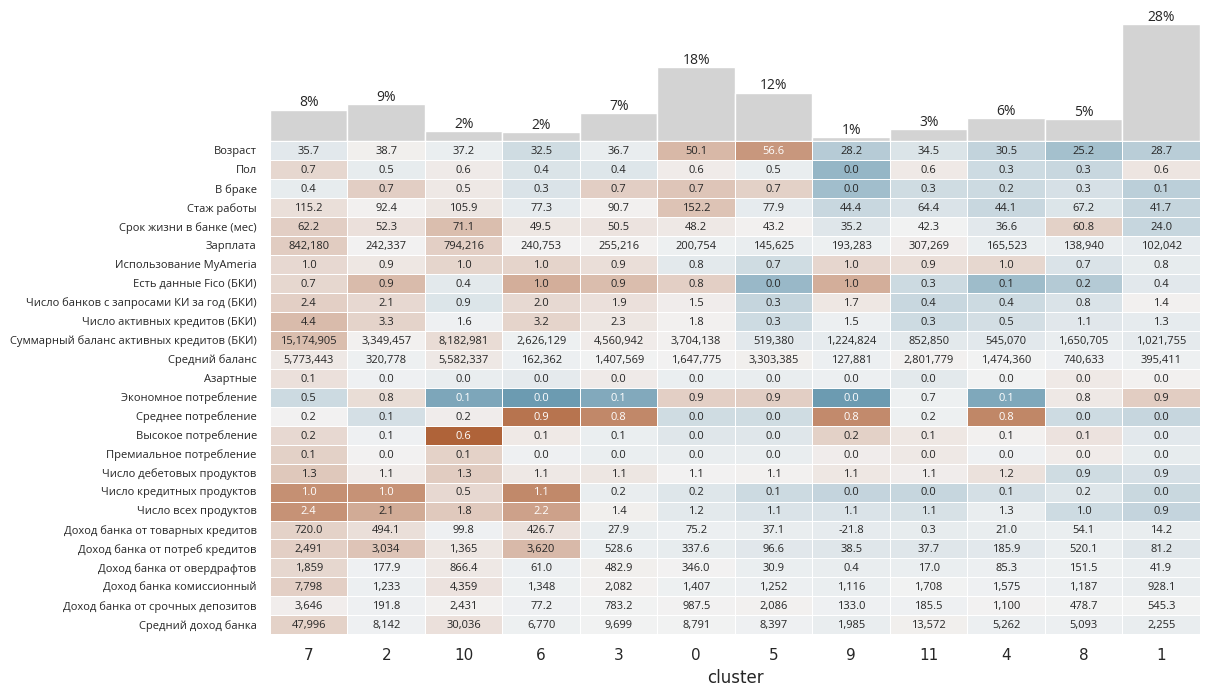

In [ ]:
cmap = sns.diverging_palette(230, 30, as_cmap=True)

scaler = SklearnStandardScaler()
scaler.fit(df_feats)

show_heatmap(
    df_feats,
    clusters,
    scaler=scaler,
    cols2drop=[],
    cmap=cmap,
    center=0,
    reorder_features=False
    )

#### Voronoi plot example

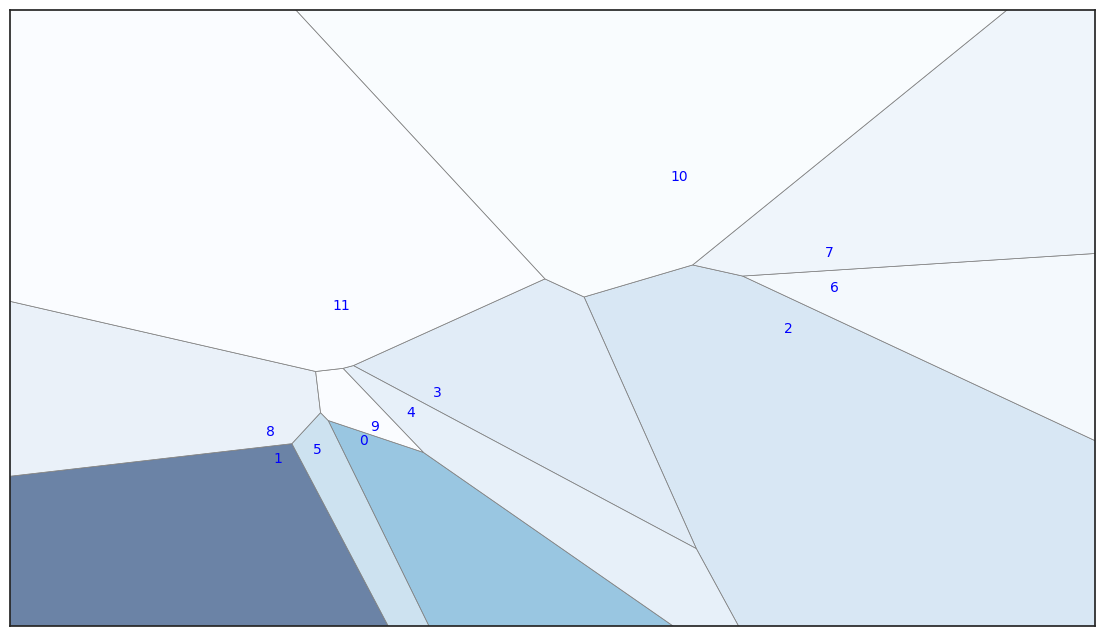

In [ ]:
clause = (total_df.outlier == 0) & (total_df.resident == 1)
dff = total_df[['Число всех продуктов', 'Средний доход банка']].loc[clause]
clusters = total_df['cluster'].loc[clause]
from sklearn.preprocessing import MinMaxScaler as SklearnMinMaxScaler

centers = get_centers(dff, clusters)
plot_voronoi(centers, clusters.value_counts().sort_index())